In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))
from IPython.display import clear_output

In [2]:
# import ML tools
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from functools import partial
import pickle
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope as ho_scope
from collections import defaultdict
from itertools import product

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


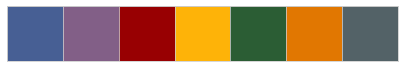

In [4]:
# import custom palette
import my_palette as mp

In [5]:
# set option for palette argument
my_palette = ['xkcd:' + c for c in mp.my_colors]

In [6]:
# read in actor dataset
df = pd.read_json('../../data_wrangling/data/capstone2_optimized_target_ds.json')

In [7]:
# observe dimensionality of dataset
df.shape

(11610, 28)

In [8]:
# separate data into features and target
X = df.drop('revenue', axis=1)
y = df['revenue']

In [9]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

For this analysis, I will use a custom optimization function to perform gradient descent.<br>
XGBoost needs a twice differentiable function to optimize.<br>
My target has a broad range of scale, which will give both large and small errors.<br>
The Huber loss behaves like RMSE for small errors and MAE for larger values.<br>
Since it is not twice differentiable, I will need to use the PseudoHuber loss, instead.<br>
I believe this choice is better suited to optimize the model selection over either RMSE or MAE, alone.

The PseudoHuber loss has a hyperparameter, delta, that needs to be chosen.<br>
This will determine the region where the function will switch between behaving like either RMSE or MAE.

In [10]:
def huber(loss, delta):
    """Return Huber loss from original loss and chosen delta"""
    loss = np.abs(loss)
    flag = loss > delta
    huber_loss = (~flag) * (0.5 * loss ** 2) - (flag) * delta * (0.5 * delta - loss)
    
    return huber_loss

In [11]:
def plot_losses(losses):
    """Plot original error and returned Huber loss"""
    plt.title('Model Error vs. Huber Loss')
    
    # get MSE
    mse_loss = losses ** 2
    plt.plot(losses, mse_loss, label='MSE', color='k', linestyle='-.')
    # get MAE
    mae_loss = np.abs(losses)
    plt.plot(losses, mae_loss, label='MAE', color=mp.colors(5), linestyle='--')
    
    for delta in range(100, 900 + 1, 200):
        # get Huber loss
        huber_loss = huber(losses, delta)
        # plot losses
        sns.lineplot(losses, huber_loss, label=delta)
    
    # set scale to best display any range of losses
    y_scale = int(np.log10(losses[-1]))
    y_limit = losses[-1] ** 2 / (2 * 10 ** (y_scale - 3))
    plt.ylim(0, y_limit)
    
    plt.xlabel('Error')
    plt.ylabel('Huber Loss')
    
    plt.legend(title='Delta', loc=6, bbox_to_anchor=(1, 0.5))

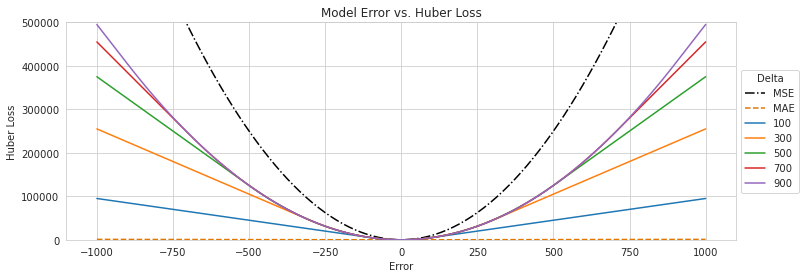

In [12]:
# observe regularization of small errors using Huber loss
plot_losses(np.linspace(-1e3, 1e3, 100))

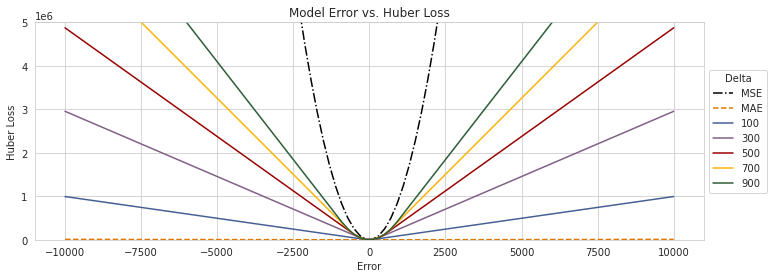

In [13]:
# observe regularization of moderate errors using Huber loss
plot_losses(np.linspace(-1e4, 1e4, 100))

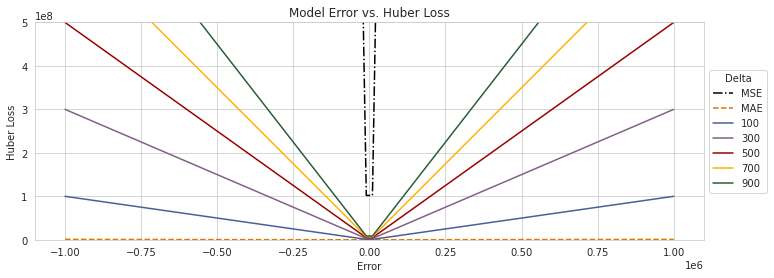

In [14]:
# observe regularization of large errors using Huber loss
plot_losses(np.linspace(-1e6, 1e6, 100))

In [15]:
def gradient(labels, preds, delta):
    """Return gradient of Pseudo-Huber loss"""
    errors = preds - labels
    scale = delta**2 + errors**2
    grad = errors * np.power(scale, -0.5)
    
    return grad

In [16]:
def hessian(labels, preds, delta):
    """Return hessian of Pseudo-Huber loss"""
    errors = labels - preds
    scale = delta**2 + errors**2
    hess = delta**2 * np.power(scale, -3/2.0)
    
    return hess

In [17]:
def pseudo_huber(preds, dtrain, delta):
    """Return gradient and hessian of Pseudo-Huber loss"""
    labels = dtrain.get_label()
    grad = gradient(labels, preds, delta=delta)
    hess = hessian(labels, preds, delta=delta)
    
    return grad, hess

My target has been transformed using the log scale.<br>
I need to convert the test data and predictions back to dollar amounts, before getting the errors.

In [18]:
def eval_error(preds, dtrain):
    """Return mean absolute error in dollar values"""
    labels = dtrain.get_label()
    errors = np.exp(preds) - np.exp(labels)
    mae_dollars = np.mean(np.absolute(errors))
    
    return '$_mae', mae_dollars

Accuracy and performace can vary between different training methods.<br>
I will create a custon cross validation function from scratch to compare with the built in XGBoost version.<br>
I will compare the differences between using CPU and GPU computing, as well.

In [19]:
def get_xgbr_train(dtrain, dtest, delta, processor_type, 
                   params={}, max_boost_round=500, booster='gbtree'):
    """Return trained Learning API XGBoost model and training results"""
    # instantiate empty dict to store evaluation metrics
    results = {}
    
    # add operational parameters
    params['booster'] = booster
    params['disable_default_eval_metric'] = 1
    params['tree_method'] = processor_type
    
    # set evaluation data
    watchlist = [(dtrain, 'train'), (dtest, 'test')]
    
    # establish early stopping limit
    early_stopping_limit = 100
    
    # use partial function to enable selection of delta parameter of PseudoHuber Loss
    train_pseudohuber = partial(pseudo_huber, delta=delta)
    
    # instantiate regressor
    model = xgb.train(params, dtrain, num_boost_round=max_boost_round, evals=watchlist, 
                      obj=train_pseudohuber, feval=eval_error, 
                      early_stopping_rounds=early_stopping_limit, 
                      evals_result=results, verbose_eval=False)
            
    return model, results

This is the custom cross validation function built from scratch.

In [20]:
def get_scratch_cv(
    features, target, delta, processor_type, 
    params={}, max_boost_round=500, booster='gbtree'):
    """Return CV results with statistics from best iteration of each fold"""
    # create default dict to hold MAE statistics from each fold
    cv_results = defaultdict(list)
    
    # instantiate KFold object
    folds = KFold(n_splits=10, random_state=27, shuffle=True)
    
    # split data and run 10 folds
    for train_index, test_index in folds.split(features, target):
        train_features = features.iloc[train_index]
        train_target = target.iloc[train_index]
        test_features = features.iloc[test_index]
        test_target = target.iloc[test_index]
        
        # convert data for faster training
        dtrain = xgb.DMatrix(data=train_features, label=train_target, nthread=-1)
        dtest = xgb.DMatrix(data=test_features, label=test_target, nthread=-1)
        
        # instantiate and fit model
        model, results = get_xgbr_train(
            dtrain, dtest, delta, processor_type, params, max_boost_round, booster)
        
        # get iteration with best test MAE
        best_iter = model.best_iteration
        # get training MAE from iteration of best test MAE
        train_mae = results['train']['$_mae'][best_iter]
        # get best test MAE
        test_mae = results['test']['$_mae'][best_iter]
        # get boosting round with best CV test MAE average
        n_boost = best_iter + 1 
        
        # save fold results to default dict
        cv_results['test_mae'].append(test_mae)
        cv_results['train_mae'].append(train_mae)
        cv_results['n_boost'].append(n_boost)

    return cv_results

Here is the function which uses XGBoost's built in cross validation method.

In [21]:
def get_xgbr_cv(features, target, delta, processor_type, 
                params={}, max_boost_round=500, booster='gbtree'):
    """Return Learning API XGBoost CV evaluation results"""
    # instantiate KFold object
    folds = KFold(n_splits=10, random_state=27, shuffle=True)

    # convert data for faster training
    dtrain = xgb.DMatrix(data=features, label=target, nthread=-1)

    # add operational parameters
    params['booster'] = booster
    params['disable_default_eval_metric'] = 1
    params['tree_method'] = processor_type

    # use partial function to enable selection of delta parameter of PseudoHuber Loss
    train_pseudohuber = partial(pseudo_huber, delta=delta)
    
    # establish early stopping limit
    early_stopping_limit = 100
    
    # create dict to hold scores for best boosting round
    cv_results = {}
    
    # get cross validation history
    cv_hist = xgb.cv(params, dtrain, num_boost_round=max_boost_round, nfold=10, 
                     folds=folds, obj=train_pseudohuber, feval=eval_error, 
                     early_stopping_rounds=early_stopping_limit, 
                     verbose_eval=False, seed = 27)
    
    # get index of boosting round with best CV test MAE average
    best_index = cv_hist['test-$_mae-mean'].argmin()
    # get best CV test MAE average
    test_mae = cv_hist.iloc[best_index]['test-$_mae-mean']
    # get CV training MAE average from best boosting round
    train_mae = cv_hist.iloc[best_index]['train-$_mae-mean']
    # get boosting round with best CV test MAE average
    n_boost = best_index + 1
    
    # save results to default dict
    cv_results['test_mae'] = test_mae
    cv_results['train_mae'] = train_mae
    cv_results['n_boost'] = n_boost

    return cv_results

First, I will select an optimum delta hyperparameter.<br>
The choice will depend on the errors produced from a base model, before tuning any of its hyperparameters.

In [22]:
def make_money(number):
    """Return dollar formatted string"""
    dollar = '${:,.2f}'.format(number)
    
    return dollar

In [23]:
def print_cv_mae(features, target, delta, cv_type, processor_type):
    """Print average mean absolute errors and boosting rounds from 10 fold cv"""
    # get results from 10 fold cross validation
    cv_results = cv_type(features, target, delta, processor_type)
    # get overall average test MAE of the 10 folds
    test_mean = np.mean(cv_results['test_mae'])
    # get overall average training MAE of the 10 folds
    train_mean = np.mean(cv_results['train_mae'])
    # get average number of boosting rounds
    n_boost = np.mean(cv_results['n_boost'])
    
    print('Delta: {}\nTest MAE: {}\nTraining MAE: {}\nBoost Rounds: {}\n'\
          .format(delta, make_money(test_mean), 
                  make_money(train_mean), int(np.round(n_boost))))

In [24]:
%%time
# observe average custom CV scores for delta=100
print_cv_mae(X_train, y_train, 1e2, get_scratch_cv, 'gpu_hist')

Delta: 100.0
Test MAE: $38,044,088.80
Training MAE: $30,515,215.00
Boost Rounds: 258

CPU times: user 11.3 s, sys: 152 ms, total: 11.4 s
Wall time: 11.5 s


In [25]:
%%time
# observe average custom CV scores for delta=50
print_cv_mae(X_train, y_train, 50, get_scratch_cv, 'gpu_hist')

Delta: 50
Test MAE: $36,859,853.60
Training MAE: $26,608,804.40
Boost Rounds: 262

CPU times: user 12.3 s, sys: 103 ms, total: 12.4 s
Wall time: 12.5 s


In [26]:
%%time
# observe average custom CV scores for delta=20
print_cv_mae(X_train, y_train, 20, get_scratch_cv, 'gpu_hist')

Delta: 20
Test MAE: $36,536,042.80
Training MAE: $22,354,284.50
Boost Rounds: 229

CPU times: user 12.1 s, sys: 79.7 ms, total: 12.2 s
Wall time: 12.2 s


In [27]:
%%time
# observe average custom CV scores for delta=10
print_cv_mae(X_train, y_train, 10, get_scratch_cv, 'gpu_hist')

Delta: 10
Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Boost Rounds: 221

CPU times: user 12.8 s, sys: 103 ms, total: 12.9 s
Wall time: 12.9 s


In [28]:
%%time
# observe average custom CV scores for delta=1
print_cv_mae(X_train, y_train, 8, get_scratch_cv, 'gpu_hist')

Delta: 8
Test MAE: $36,553,070.80
Training MAE: $19,211,918.05
Boost Rounds: 205

CPU times: user 11.9 s, sys: 99.7 ms, total: 12 s
Wall time: 12 s


In [29]:
%%time
# observe average custom CV scores for delta=1
print_cv_mae(X_train, y_train, 7.9, get_scratch_cv, 'gpu_hist')

Delta: 7.9
Test MAE: $35,937,576.60
Training MAE: $16,294,062.10
Boost Rounds: 254

CPU times: user 14 s, sys: 110 ms, total: 14.1 s
Wall time: 14.1 s


In [30]:
%%time
# observe average custom CV scores for delta=1
print_cv_mae(X_train, y_train, 7.8, get_scratch_cv, 'auto')

Delta: 7.8
Test MAE: $35,889,126.80
Training MAE: $17,142,067.60
Boost Rounds: 233

CPU times: user 4min 4s, sys: 8.66 s, total: 4min 13s
Wall time: 10.6 s


In [31]:
%%time
# observe average custom CV scores for delta=1
print_cv_mae(X_train, y_train, 7.7, get_scratch_cv, 'auto')

Delta: 7.7
Test MAE: $36,458,244.40
Training MAE: $19,120,002.00
Boost Rounds: 214

CPU times: user 3min 50s, sys: 8.77 s, total: 3min 58s
Wall time: 10 s


Speed up is only slightly better with higher deltas in this range.<br>
The excellent overfit ratio resulting from the largest delta value is not worth the significant increase in the test error.

I would prefer to start with a model that has an overfit ratio that is no lower than 87%.<br>
This was the value I was able to achieve after hyperparameter tuning when using the MAE loss to optimize training.<br>
Later, I will try to improve that value through the tuning of the regularization hyperparameters.

Also, the best test score reached, so far, was $41,215,414.04 obtained after the target optimization.<br>
I will try to improve on this value, as well.

I will continue to focus on the hybrid loss, simultaneously optimizing both test and overfit values.

In [32]:
def test_deltas(features, target, delta_min, delta_max, cv_type, processor_type):
    """Return DataFrame with CV results over range of PseudoHuber deltas"""
    # create iterable of deltas
    deltas = np.arange(delta_min, delta_max + 1, 1)
    #create default dict to store CV results
    revenue_dict = defaultdict(list)
    
    # create ten delta values to test
    for delta in deltas:
        print('Working on Delta = ', delta, '...')
        clear_output(wait=True)
        
        # create default dict to hold average CV scores
        cv_averages = defaultdict(list)
        
        # get results from 10 fold cross validation
        cv_results = cv_type(features, target, delta, processor_type)

        # create list of keys from dict returned from selected CV function
        keys = list(cv_results.keys())
        
        # get overall average scores and number of boosting rounds of the 10 folds
        test_mae_ave = np.mean(cv_results['test_mae'])
        train_mae_ave = np.mean(cv_results['train_mae'])
        n_estimator_ave = int(np.mean(cv_results['n_boost']))
        
        # store results for final comparison
        revenue_dict[delta].append(test_mae_ave)
        revenue_dict[delta].append(train_mae_ave)
        revenue_dict[delta].append(n_estimator_ave)
        
    print('Finished all {} deltas.'.format(len(deltas)))
    
    # transfer results to DataFrame
    results_df = pd.DataFrame(
        revenue_dict, index=keys).transpose().sort_values('test_mae')
    
    return results_df

In [33]:
%%time
# get DataFrame of results for deltas between 8 and 20 using custom CV on CPU
scr_cpu_results_df = test_deltas(X_train, y_train, 8, 20, get_scratch_cv, 'auto')
scr_cpu_results_df

Finished all 13 deltas.
CPU times: user 55min 5s, sys: 2min 2s, total: 57min 7s
Wall time: 2min 23s


,test_mae,train_mae,n_boost
18,35961850.4,20211092.7,259.0
8,35966674.4,14962411.9,304.0
15,36140384.8,20247115.1,237.0
17,36175045.2,18803389.7,297.0
10,36175629.2,18874769.4,242.0
16,36183036.0,18793577.8,276.0
13,36225748.8,20203117.4,243.0
19,36302819.2,22983323.9,214.0
14,36352454.4,20733131.9,233.0
20,36403307.6,20190183.2,283.0


In [34]:
%%time
# get DataFrame of results for deltas between 8 and 20 using custom CV on GPU
scr_gpu_results_df = test_deltas(X_train, y_train, 8, 20, get_scratch_cv, 'gpu_hist')
scr_gpu_results_df

Finished all 13 deltas.
CPU times: user 2min 49s, sys: 1.43 s, total: 2min 51s
Wall time: 2min 47s


,test_mae,train_mae,n_boost
10,35843487.4,18699906.50,220.0
17,35980738.8,20494878.60,247.0
18,36054667.6,20039066.80,271.0
14,36105361.6,20390352.10,223.0
15,36235838.0,20068259.90,233.0
13,36302143.8,18251410.80,264.0
12,36306589.6,18971438.80,248.0
11,36372526.8,17667692.90,261.0
16,36377920.0,21383321.60,230.0
19,36389191.6,22310973.20,211.0


In [35]:
%%time
# get DataFrame of results for deltas between 8 and 20 using XGBoost CV on CPU
cv_cpu_results_df = test_deltas(X_train, y_train, 8, 20, get_xgbr_cv, 'auto')
cv_cpu_results_df

Finished all 13 deltas.
CPU times: user 1h 36min 7s, sys: 4min 34s, total: 1h 40min 42s
Wall time: 4min 30s


,test_mae,train_mae,n_boost
8,36082427.2,10589569.4,426.0
10,36260376.4,9651152.8,497.0
18,36324298.0,21642491.6,209.0
13,36380538.2,12863152.5,421.0
15,36408818.0,11731273.0,500.0
17,36460727.6,18567554.4,278.0
16,36492193.6,16075825.2,344.0
11,36551060.0,10130210.5,500.0
14,36554821.6,13439243.2,414.0
20,36586770.0,14298316.8,455.0


In [36]:
%%time
# get DataFrame of results for deltas between 8 and 20 using custom CV on GPU
cv_gpu_results_df = test_deltas(X_train, y_train, 8, 20, get_xgbr_cv, 'gpu_hist')
cv_gpu_results_df

Finished all 13 deltas.
CPU times: user 3min, sys: 1.59 s, total: 3min 2s
Wall time: 2min 59s


,test_mae,train_mae,n_boost
10,36258228.2,22367009.6,143.0
18,36509662.4,15566597.6,367.0
17,36531468.2,21122043.6,216.0
14,36534699.2,18567674.8,248.0
12,36565754.8,18198882.0,233.0
16,36571834.4,13388767.3,418.0
15,36624134.0,21474093.4,194.0
19,36653280.0,17979649.8,305.0
13,36657295.0,19228668.8,225.0
11,36791668.0,16414339.8,264.0


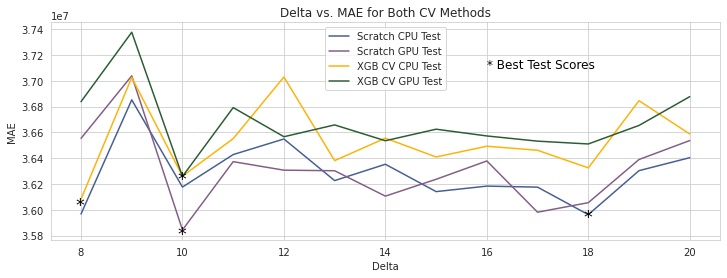

In [37]:
# plot cross validation results for deltas between 8 and 20 for both CV methods

sns.lineplot(x=scr_cpu_results_df.index, y=scr_cpu_results_df['test_mae'], 
             label='Scratch CPU Test', color=mp.colors(0))
sns.lineplot(x=scr_gpu_results_df.index, y=scr_gpu_results_df['test_mae'], 
             label='Scratch GPU Test', color=mp.colors(1))
sns.lineplot(x=cv_cpu_results_df.index, y=cv_cpu_results_df['test_mae'], 
             label='XGB CV CPU Test', color=mp.colors(3))
sns.lineplot(x=cv_gpu_results_df.index, y=cv_gpu_results_df['test_mae'], 
             label='XGB CV GPU Test', color=mp.colors(4))

plt.text(x=17.9, y=3.59e7, s='*', size='xx-large', color='k')
plt.text(x=9.9, y=3.577e7, s='*', size='xx-large', color='k')
plt.text(x=7.9, y=3.6e7, s='*', size='xx-large', color='k')
plt.text(x=9.9, y=3.62e7, s='*', size='xx-large', color='k')
plt.text(x=16, y=3.71e7, s='* Best Test Scores', size='large', color='k')

plt.xlabel('Delta')
plt.ylabel('MAE')

plt.legend(loc=9)
plt.title('Delta vs. MAE for Both CV Methods');

Scratch CPU: delta = 18<br>
Scratch GPU: delta = 10<br>
XGB CPU: delta = 8<br>
XGB GPU: delta = 10

In [38]:
%%time
# get statistics for using CPU Scratch CV with delta = 18
{k: np.mean(v) for k, v in get_scratch_cv(X_train, y_train, 18, 'auto').items()}

CPU times: user 4min 14s, sys: 9.72 s, total: 4min 23s
Wall time: 11.1 s


{'test_mae': 35961850.4, 'train_mae': 20211092.7, 'n_boost': 259.8}

In [39]:
%%time
# get statistics for using GPU Scratch CV with delta = 10
{k: np.mean(v) for k, v in get_scratch_cv(X_train, y_train, 10, 'gpu_hist').items()}

CPU times: user 15.9 s, sys: 279 ms, total: 16.1 s
Wall time: 13 s


{'test_mae': 35843487.4, 'train_mae': 18699906.5, 'n_boost': 220.6}

In [40]:
%%time
# get statistics for using CPU XGB CV with delta = 8
{k: v for k, v in get_xgbr_cv(X_train, y_train, 8, 'auto').items()}

CPU times: user 6min 13s, sys: 13 s, total: 6min 26s
Wall time: 16.2 s


{'test_mae': 36082427.2, 'train_mae': 10589569.4, 'n_boost': 426}

In [41]:
%%time
# get statistics for using GPU XGB CV with delta = 10
{k: v for k, v in get_xgbr_cv(X_train, y_train, 10, 'gpu_hist').items()}

CPU times: user 13.5 s, sys: 302 ms, total: 13.8 s
Wall time: 9.91 s


{'test_mae': 36258228.2, 'train_mae': 22367009.6, 'n_boost': 143}

Choosing GPU Scratch CV with delta = 10.

There are a lot of hyperparameters to tune.<br>
I will break them into three groups.<br>
 - Tree Structure Based Complexity Moderation (Bias/Variance Trade-off)
     - learning_rate: Controls amount errors are corrected from previous round 
         - Lower --> Smaller Weights --> Less Complexity
     - max_depth: Controls how deep trees are allowed to grow 
         - Higher --> More Layers in Trees --> More Complexity
     - min_child_weight: Controls weight required to create new node 
         - Higher --> More Samples Needed To Split a Node --> Less Complexity
     - n_estimators: The number of boosting rounds 
         - Higher --> More Trees --> More Complixity
 - Stochastic Based Complexity Moderation (Used to Lower Variance)
     - colsample_bylevel: Fraction of features to use at each level
         - Lower --> Sample is Less Representative of Data --> Less Complexity
     - subsample: Fraction of observations to use at each boosting round
         - Lower --> Sample is Less Representative of Data --> Less Complexity
 - Regularization Based Complexity Moderation (Used to Lower Variance)
     - reg_lambda: Ridge (L2) regularization
         - Higher --> Errors are more heavily penalized --> Less Complexity

I will use the mean absolute error (MAE) as my test statistic, as opposed to the root mean squared error (RMSE).<br>
The RMSE tends to increase more rapidly than the MAE, as the sample size increases.<br>
I will be using cross validation, extensively, throughout this analysis.<br>
Hense, RMSE may be problematic, when comparing errors between training and test performances.

To get some perspective on this loss, I'll show the broad range of average revenues for the actors' movies.

In [42]:
# get average movie revenue and revenue range for all actors in training data
f'Average target: ${np.mean(np.exp(y_train)):,.2f} \
    Target Range: (${np.min(np.exp(y_train)):,.2f}, ${np.max(np.exp(y_train)):,.2f})'

'Average target: $81,851,821.32     Target Range: ($1.24, $999,601,802.16)'

With this range so wide, it is important to observe the standard deviation of the data, as well.

In [43]:
# get standard deviation of movie revenue for all actors in training data
f'Standard Deviation of Target: ${np.std(np.exp(y_train)):,.2f}'

'Standard Deviation of Target: $120,817,369.06'

Though the average error is large, it is well within one standard deviation of the target values.

I will create some residual plots, now.

In [44]:
def plot_predictions(features, target, deltas):
    """Plot observed target vs. predictions for provided deltas"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # run training and plot using different deltas
    for delta in deltas:
        # get model
        model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist')[0]
        # get targets and predictions in dollar amounts
        labels = np.exp(y_test)
        preds = np.exp(model.predict(dtest))
        # plot errors
        sns.scatterplot(labels, preds, label=delta)
        sns.regplot(labels, preds, scatter=False)
    
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    plt.legend(title='Delta')
    plt.title("Ground Truth vs Predicted")

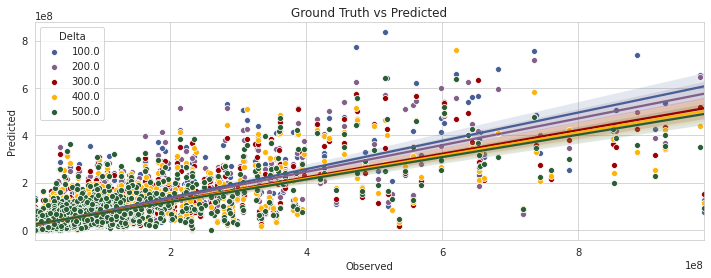

In [45]:
# plot observed target vs. predictions for a range of deltas
plot_predictions(X_train, y_train, np.arange(1e2, 5e2 + 1, 100))

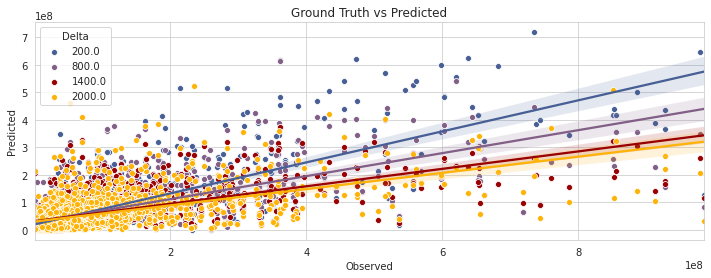

In [46]:
# plot observed target vs. predictions for a range of deltas
plot_predictions(X_train, y_train, np.arange(2e2, 2e3 + 1, 600))

There's one extreme outlier that is quite obvious.

In [47]:
def plot_residuals(features, target, deltas):
    """Plot predictions vs.residuals for provided deltas"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # run training and plot using different deltas
    for delta in deltas:
        # get model
        model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist')[0]
        # get targets and predictions in dollar amounts
        labels = np.exp(y_test)
        preds = np.exp(model.predict(dtest))
        # plot errors
        sns.residplot(preds, labels, label=delta, lowess=True, 
                      scatter_kws={'s':10}, line_kws={'linewidth':3})
    
    plt.xlabel('Predicted Actor Value')
    plt.ylabel('Residuals')
    
    plt.legend(title='Delta')
    plt.title("Predicted vs Residuals")

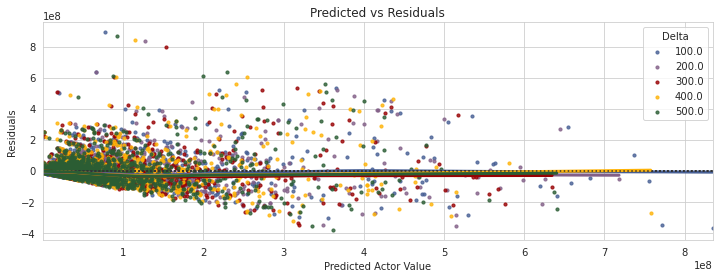

In [48]:
# plot predictions vs. residuals for a range of deltas
plot_residuals(X_train, y_train, np.arange(1e2, 5e2 + 1, 100))

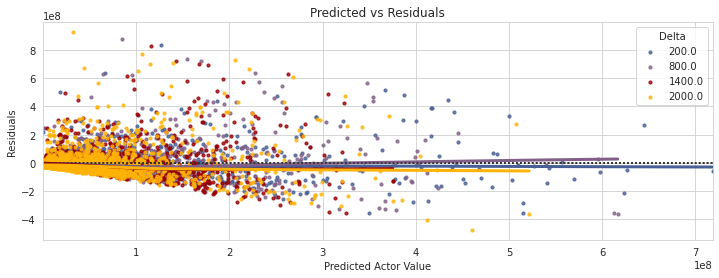

In [49]:
# plot predictions vs. residuals for a range of deltas
plot_residuals(X_train, y_train, np.arange(2e2, 2e3 + 1, 600))

Aside from the handfull of outliers, the residual appear well distributed about 0.

In [50]:
def plot_residual_distribution(features, target, deltas):
    """Plot distribution of residuals for provided deltas"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # run training and plot using different deltas
    for delta in deltas:
        # get model
        model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist')[0]
        # get targets and predictions in dollar amounts
        labels = np.exp(y_test)
        preds = np.exp(model.predict(dtest))
        # plot errors        
        sns.distplot(labels - preds, label=delta, bins=300, rug=True, axlabel='Residuals')

    plt.ylabel('Frequency')
    
    plt.legend(title='Delta')
    plt.title('Distribution of Residuals')

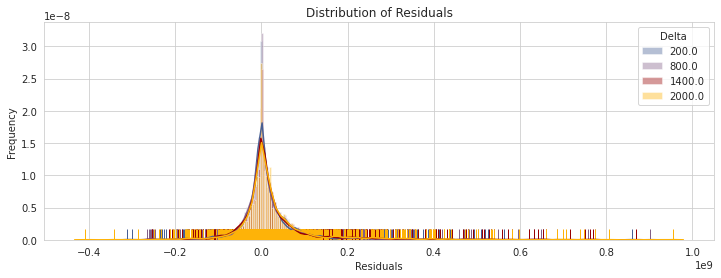

In [51]:
# plot residuals distribution for a range of deltas
plot_residual_distribution(X_train, y_train, np.arange(2e2, 2e3 + 1, 600))

The distribution of residuals appers fairly normal, aside from the extreme outliers.

I will take a look at the feature importance for the predictions

In [52]:
def plot_feature_importance(features, target, delta, importance_type):
    """Plot predictors by chosen importance to model"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # get model
    model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist')[0]
    # create dict to hold feature importance
    importance_dict = model.get_score(importance_type=importance_type)
    # plot feature importance
    sns.barplot(x=list(importance_dict.keys()), 
                y=list(importance_dict.values()), 
                palette=my_palette).set_xticklabels(importance_dict.keys(), 
                                                        rotation=70)

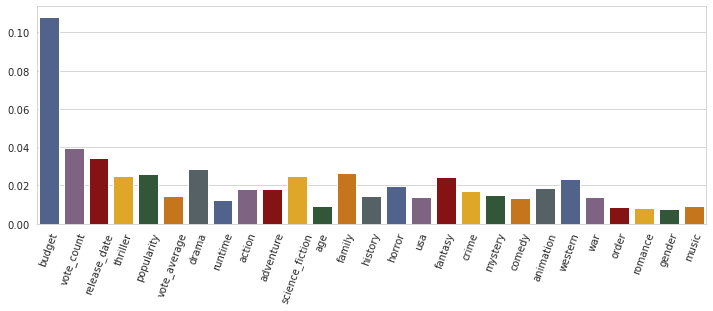

In [53]:
# plot feature importance by selected metric
plot_feature_importance(X_train, y_train, 2e2, 'gain')

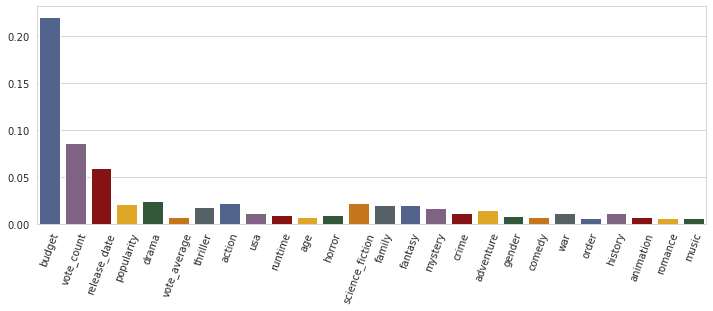

In [54]:
# plot feature importance by selected metric
plot_feature_importance(X_train, y_train, 4e2, 'gain')

It is not surprising that the budget is the most important feature for predicting revenue.<br>
I would not have expected runtime to be such a strong predictor, though.

I will perform an informed (Bayesian) search technique to find the best hyperparameters.<br>
This method has advantages over a brute force grid search, which tries all combinations of hyperparameters.<br>
It is closer to a random grid search, except the choices of parameters are based on the results of previous choices.

 > **BAYESIAN HYPERPARAMETER SEARCH**

My strategy will be to march through the hyperparameters, adding them one by one to the search.<br>
I will be looking for the best range of the current hyperparameter to keep, before progressing to the next one.<br>
This will help to reduce the number of possible local minima that the model may fall into along the search.<br>
It will reduce search time, as well, as some parameters are additive in computation time, as their ranges expand.<br>
Hense, I will be applying appropriate upper limits to those values during the search.

As hyperparameters are added, the optimal ranges for previous ones may change.<br>
I will be monitoring these needs along the way, making appropriate adjustments when necessary.<br>
I will plot cross validated results over a range of values to highlight the trade off between accuracy and overfitting.

The first hyperparameters to lock down are the number of estimators and the learning rate.<br>
Some literature suggests to begin by finding the best product of these two hyperparameters.<br>
In a nod to fluid dynamics, I will call this product the model's tree flow rate.

I'll target different numbers of trees, while searching over a range of tree flows.

I will start with observing the results of using only 10 trees.

I have a dual goal of minimizing both the test error and the degree of overfitting.<br>
I will create a custom loss function that will guide the optimization procedure to a model that fulfills both goals.<br>
This will ensure that the final model is both accurate and generalizable.

The hybrid loss will be the sum of the test loss with the difference between the test loss and the training loss.

$Hybrid Loss=Test Error + Overfit Error$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$= Test Loss + (Test Loss - Training Loss)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$= 2 * Test Loss - Training Loss$

I am using the results from a cross validation function to supply the metrics needed to construct a hybrid loss.<br>
The function returns the results from 10 folds for both the test and training scores.<br>
I will observe the ratio of average training loss to average test loss over each fold to get a sense of overfitting.<br>
The hybrid loss will be the metric that is being optimized during the search for the best estimators for each batch of trials.

In [55]:
def objective(params, features, target, delta, 
              cv_type, processor_type, max_boost_round, 
              booster):
    """Returns CV results for XGB model"""
    # enable iteration marker to be GLOBAL variable
    global global_iterations
    # update marker
    global_iterations += 1
    # get all scores from 10 fold cross-validation
    cv_results = cv_type(features, target, delta, 
                         processor_type, params, max_boost_round=max_boost_round, 
                         booster=booster)
    # get average scores from 10 fold cross-validation
    average_test_mae = np.mean(cv_results['test_mae'])
    average_train_mae = np.mean(cv_results['train_mae'])
    # get average number of boosting rounds
    average_n_estimators = int(np.round(np.mean(cv_results['n_boost'])))

    return {
        'trial': global_trials, 
        'batch': global_batches, 
        'iteration': global_iterations, 
        'loss': average_test_mae, 
        'train_mae': average_train_mae, 
        'n_boost': average_n_estimators, 
        'params': params, 
        'status': STATUS_OK
    }

In [56]:
def run_trial_batches(features, target, delta, 
                      cv_type, processor_type, 
                      hp_space, trials, 
                      batch_size=10, max_batches=10, max_boost_round=500, 
                      booster='gbtree'):
    """Runs informed search trials in batches with a cap on the number of batches"""
    # enable trial marker to be GLOBAL variable (allows continuation of existing trial)
    global global_trials
    global_trials +=1
    # check for newly initialized trials object
    if not trials.losses():
        # initialize best loss and number of iterations for new trials object
        last_best = 0
        last_iters = 0
    else:
        # initialize best loss and number of iterations from imported trials object
        last_best = trials.best_trial['result']['loss']
        last_iters = len(trials.losses())
    # initialize best loss for batch
    new_best = 0
    # initialize early stop flag
    early_stop = 'GO!'
    # run optimization search over all batches
    for batch in range(max_batches):
        # check for early stop
        if early_stop == 'GO!':
            # enable batch marker to be GLOBAL variable
            global global_batches
            # update trials batch counter
            global_batches += 1
            # set iterations argument for maximum evaluations parameter of fmin function
            n_iters = batch_size * (batch + 1) + last_iters
            # use partial function to lower number of trials used to initialize warm start
            fmin_suggest = partial(tpe.suggest, n_startup_jobs=1)
            # use partial function to enable selection of trials data
            fmin_objective = partial(
                objective, features=features, target=target, delta=delta, 
                cv_type=cv_type, processor_type=processor_type, 
                max_boost_round=max_boost_round, booster=booster)
            # run one batch
            fmin(fn=fmin_objective, space=hp_space, max_evals=n_iters, trials=trials, 
                 algo=fmin_suggest, rstate=np.random.RandomState(27))
            # save updated results to M.2 (stores most recent trials object)
            pickle.dump(trials, open('./xgbr_trials/xgbr_trials_last.pkl', 'wb'))
            # capture current optimal loss
            new_best = trials.best_trial['result']['loss']
            # check that batch optimized
            if last_best == new_best:
                early_stop = 'STOP!'
            last_best = new_best

The optimization search will be callable for a maximum of 10 batches with a default of 10 fits for each batch.<br>
Early stopping will be called if the loss function has not improved over a full batch from the best value of the previous batch.

Before I start the search, I want to get a trials object for the base model for easy comparison.

 > **xgbr_trials_0**

In [57]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_0 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [58]:
# create informed search space using a single default value
hp_space = {
    'max_depth': ho_scope.int(hp.uniform('max_depth', 6, 6.1))
}
# call optimization function
fmin_objective = partial(objective, features=X_train, target=y_train, 
                         delta=10, cv_type=get_scratch_cv, 
                         processor_type='gpu_hist', max_boost_round=500, 
                         booster='gbtree')
fmin(fn=fmin_objective, space=hp_space, max_evals=1, trials=xgbr_trials_0, 
     algo=tpe.suggest, rstate=np.random.RandomState(27))

# save trials object
pickle.dump(xgbr_trials_0, open('./xgbr_trials/xgbr_trials_0.pkl', 'wb'))

100%|██████████| 1/1 [00:12<00:00, 12.91s/trial, best loss: 35843487.4]


In [59]:
def make_trials_df(trials):
    """Makes a DataFrame from results dict of objective function sorted by loss"""
    # convert dict to DataFrame
    trials_df = pd.DataFrame(trials.results)
    # extract nested parameter dicts to separate DataFrame
    params_df = pd.DataFrame(trials_df['params'].to_list()).drop(
        ['booster', 'disable_default_eval_metric', 'tree_method'], axis=1)
    # combine DataFrames, clean up, and order by best losses
    trials_df = trials_df.drop(
        ['params', 'status'], axis=1).join(
        params_df).sort_values('loss', ascending=True)
    
    return trials_df

In [60]:
# get results DataFrame
trials_0_df = make_trials_df(xgbr_trials_0)
trials_0_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,max_depth
0,0,0,1,35843487.4,18699906.5,221,6


In [61]:
def print_best_trial(trials):
    # get base metrics
    test_mae = trials.best_trial['result']['loss']
    train_mae = trials.best_trial['result']['train_mae']
    n_boost = trials.best_trial['result']['n_boost']

    print('Test MAE: {}\nTraining MAE: {}\nNum Boosters: {}'.format(
        make_money(test_mae), make_money(train_mae), n_boost))

In [62]:
# observe metrics of best trial from base trials object
print_best_trial(xgbr_trials_0)

Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Num Boosters: 221


I'll confirm that this result is the same as the one obtained by using the custom cross validation, directly.

In [63]:
# observe average CV test MAE and overfit ratio for delta=10
print_cv_mae(X_train, y_train, 10, get_scratch_cv, 'gpu_hist')

Delta: 10
Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Boost Rounds: 221



The default value is 0.3

 > **learning_rate**

In [64]:
def scratch_grid_cv(features, target, delta, cv_type, 
                    processor_type, grid, booster):
    """Return search grid results from custom cross validation function"""
    # extract search target hyperparameter to display
    for key, value in grid.items():
        if len(value) > 1:
            searched_param = key
    # create list of all hyperparameter combinations
    keys = grid.keys()
    values = (grid[key] for key in keys)
    combos = [dict(zip(keys, combo)) for combo in product(*values)]
    # create empty list to hold MAE from each fold
    grid_dict = defaultdict(list)
    # perform grid search
    for params in combos:
        print(searched_param, ':', params[searched_param], '...')
        # collect 10 fold cv scores for hyperparameter combination
        scores_dict = cv_type(features, target, delta, processor_type, 
                              params, booster=booster)
        # get average scores and trees for hyperparameter combination over each CV fold
        grid_dict['params'].append(params)
        test_mean = np.mean(scores_dict['test_mae'])
        train_mean = np.mean(scores_dict['train_mae'])
        n_estimators_mean = np.mean(scores_dict['n_boost'])
        # update default dict with cv statistics for hyperparameter combination
        grid_dict['test_mean'].append(test_mean)
        grid_dict['n_estimators_mean'].append(n_estimators_mean)
        grid_dict['test_std'].append(np.std(scores_dict['test_mae']))
        
        print('Test MAE: {}\nTraining MAE: {}'.format(
            make_money(test_mean), make_money(train_mean)))
        print('Average Boosting Rounds: {}\n'.format(int(np.round(n_estimators_mean))))

    return grid_dict

In [65]:
def plot_hyperparameters(features, target, delta, cv_type, 
                         processor_type, grid, booster='gbtree'):
    """Plots CV results over range of one hyperparameter"""
    # run 10 fold cv grid search and get error statistics to plot
    gs_df = pd.DataFrame(
        scratch_grid_cv(X_train, y_train, delta, cv_type, processor_type, grid, booster))

    # plot errors over range for variable hyperparameter
    var_param = {k:v for (k, v) in grid.items() if len(v) > 1}
    for param, param_lst in var_param.items():
        # plot test scores
        sns.lineplot(x=param_lst, y=gs_df['test_mean'], label="Test Score", lw=2)
        plt.fill_between(param_lst, gs_df['test_mean'] - gs_df['test_std'],
                         gs_df['test_mean'] + gs_df['test_std'], alpha=0.2, lw=2)
        
        plt.xlabel(param, fontsize=15)  
        plt.ylabel("MAE", fontsize=15)

        plt.legend(bbox_to_anchor=(1.2, 0.5), loc=5, fontsize='large')
        plt.title('Hyperparameters vs. Losses', fontsize=15)

In [66]:
# create parameter search grid
param_grid = {
    'eta': np.linspace(0.06, 0.22, 9)
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22]


eta : 0.06 ...
Test MAE: $36,018,258.60
Training MAE: $26,144,379.20
Average Boosting Rounds: 484

eta : 0.08 ...
Test MAE: $35,754,930.60
Training MAE: $23,722,905.20
Average Boosting Rounds: 495

eta : 0.1 ...
Test MAE: $35,190,672.80
Training MAE: $22,065,118.00
Average Boosting Rounds: 449

eta : 0.12 ...
Test MAE: $35,161,257.40
Training MAE: $21,535,946.40
Average Boosting Rounds: 405

eta : 0.14 ...
Test MAE: $35,328,672.00
Training MAE: $21,075,046.40
Average Boosting Rounds: 365

eta : 0.16 ...
Test MAE: $35,438,444.60
Training MAE: $19,483,694.00
Average Boosting Rounds: 382

eta : 0.18 ...
Test MAE: $35,115,928.80
Training MAE: $17,755,400.10
Average Boosting Rounds: 392

eta : 0.2 ...
Test MAE: $35,490,208.40
Training MAE: $18,437,284.80
Average Boosting Rounds: 346

eta : 0.22 ...
Test MAE: $35,490,932.80
Training MAE: $17,786,449.30
Average Boosting Rounds: 317



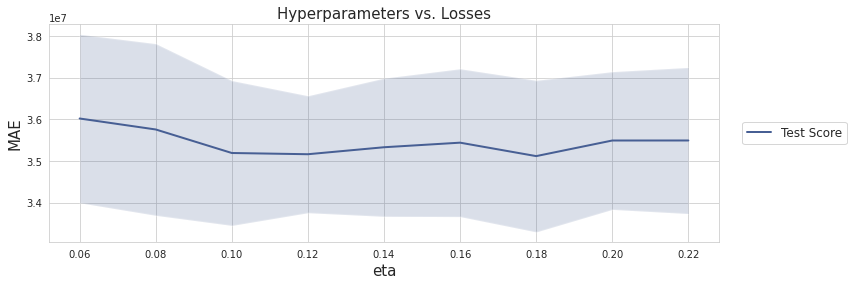

In [67]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

I'll compare this to the results of using the default learning rate of 0.3.

In [68]:
# observe metrics of best trial from base trials object
print_best_trial(xgbr_trials_0)

Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Num Boosters: 221


The learning rate sweet spot appears to be around 0.15.<br>
I will set the learning rate range to be between 0.08 and 0.2 for the hyperparameter search space.

 > **xgbr_trials_1**

In [69]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_1 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [70]:
# create informed search space  
hp_space = {
    'eta': hp.uniform('eta', 0.08, 0.2)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_1)
# save trials object
pickle.dump(xgbr_trials_1, open('./xgbr_trials/xgbr_trials_1.pkl', 'wb'))

100%|██████████| 40/40 [03:08<00:00,  4.72s/trial, best loss: 34711206.2]


In [71]:
def plot_param_search(trials):
    """Plot iterations of optimization search for hyperparmeters"""
    # establish figure height (each hyperparameter + one optimization plot)
    num_subplots = len(trials.idxs.keys()) + 1
    fig_height = num_subplots * 4
    # establish subplots
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot parameters of optimization run
    count = 1
    for key in trials.idxs:
        plt.subplot(num_subplots, 1, count)
        
        # get number of trials in run
        n_iters = len(trials.losses())
        # get iteration of optimal objective loss
        best_iter = trials.best_trial['tid'] + 1        
        # get value for hyperparameter of best model
        best_val = trials.argmin[key]
        # get list of hyperparameter values
        vals_lst = trials.vals[key]
        
        # adjust values for data type
        if key in ['max_depth', 'min_child_weight']:
            best_val = int(best_val)
            vals_lst = list(map(int, vals_lst))
        else:
            best_val = round(best_val, 6)

        # plot hyperparameters for optimization run
        plt.plot(range(1, len(trials.results) + 1), vals_lst, 
                 marker='o', color=mp.colors(4), alpha=0.8)        
        # mark off optimal hyperparameter value
        plt.hlines(best_val, n_iters * -0.05, n_iters * 1.05, linestyles = '--', 
                   label='Optimal \n' + str(key) + ': \n' + '{:,}'.format(best_val), 
                   colors=mp.colors(2))
        # mark iteration of optimal objective loss at hyperparameter value
        plt.plot(best_iter, best_val, marker='*', ms=15, color=mp.colors(2))
        count += 1
        
        plt.ylabel(key, fontsize=18)
        
        plt.legend(bbox_to_anchor=(1.31, 0.5), loc=5, fontsize='x-large')

    plt.subplot(num_subplots, 1, count)
    
    # get optimal test loss value
    best_test_loss = trials.best_trial['result']['loss']
    # get optimal training loss value
    best_training_loss = np.min([v['train_mae'] for v in trials.results])
    # set lower limit of plot
    y_min = np.min([best_test_loss, best_training_loss])

    # get largest test loss value
    worst_test_loss = np.max(trials.losses())
    # get largest training loss value
    worst_training_loss = np.max([v['train_mae'] for v in trials.results])
    # set upper limit of plot
    y_max = np.max([worst_test_loss, worst_training_loss])
    
    # set y limits
    plt.ylim(y_min * 0.9, y_max * 1.1)
    
    # plot losses for optimization run
    sns.lineplot(x=range(1, n_iters + 1), 
                 y=trials.losses(), 
                 marker='o', label='Test Loss')
    sns.lineplot(x=range(1, n_iters + 1), 
                 y=[v['train_mae'] for v in trials.results], 
                 marker='o', label='Training Loss')
    
    # mark off best test loss
    plt.hlines(best_test_loss, n_iters * -0.05, n_iters * 1.05, linestyles = '--', 
               colors='k')
    # mark iteration of optimal test loss
    plt.plot(best_iter, best_test_loss, marker='*', ms=15, color='k', 
             label='Test Error: \n' + '${:,.2f}'.format(best_test_loss))
    
    # get training loss for model with best test loss
    corresponding_training_loss = trials.best_trial['result']['train_mae']
    # put training loss value for model with best test loss in legend
    plt.plot(0, 0, linewidth=0, label='Training Error: \n' + '${:,.2f}'.format(
                   corresponding_training_loss))

    plt.xlabel('Iteration (Best Iteration: ' + str(best_iter) + ')', fontsize=15)
    plt.ylabel('MAE', fontsize=18)
    
    plt.legend(bbox_to_anchor=(1.33, 0.5), loc=5, fontsize='x-large', 
               title='Best Iteration', title_fontsize='x-large')
    plt.suptitle('Hyperparameter Optimization Sequence', y=0.93, fontsize=23)

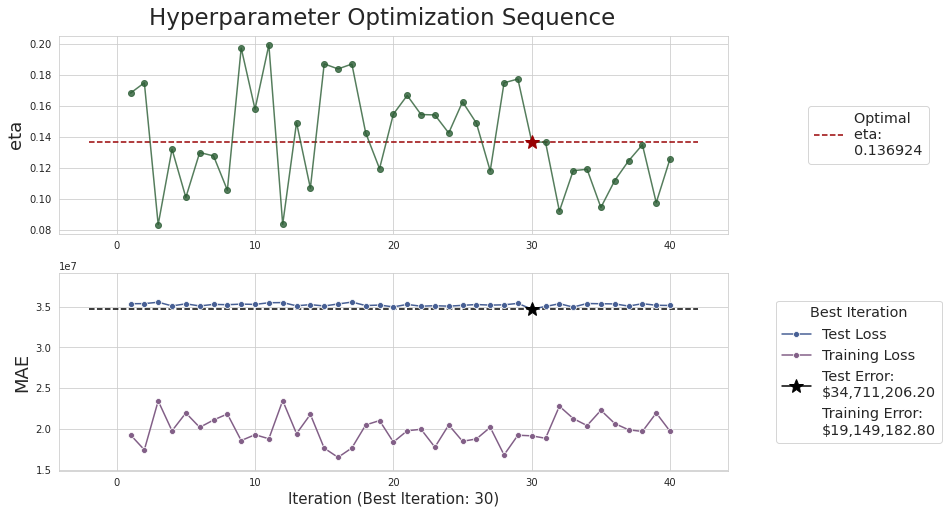

In [72]:
# plot informed search history
plot_param_search(xgbr_trials_1)

The informed search does not appear constrained by the range of allowable values for the learning rate.

The three losses being tracked will always appear in this order.<br>
The goals are to lower the test loss while bringing the training loss nearer to it.<br>
Individual improvements with respect to one of these goals will be seen in a lower hybrid loss.

In [73]:
# get results DataFrame
trials_1_df = make_trials_df(xgbr_trials_1)
trials_1_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,eta
29,1,3,30,34711206.2,19149182.8,436,0.136924
32,1,4,33,34967768.0,21273690.0,420,0.118080
19,1,2,20,34988719.0,18381281.3,425,0.154680
30,1,4,31,35038632.0,18847987.0,450,0.136421
21,1,3,22,35072353.2,19953966.0,371,0.154406
23,1,3,24,35075230.6,20480780.0,382,0.142456
36,1,4,37,35087966.0,19892671.4,453,0.124418
14,1,2,15,35098556.8,17639418.4,376,0.187195
5,1,1,6,35103824.6,20189872.2,412,0.129835
3,1,1,4,35109786.0,19765366.4,429,0.131951


I'll show the base model scores, again.

In [74]:
# observe metrics of best trial from base trials object
print_best_trial(xgbr_trials_0)

Test MAE: $35,843,487.40
Training MAE: $18,699,906.50
Num Boosters: 221


The top model has an improved hybrid loss by just under a million and a half dollars.<br>
The test score is higher by over a million dollars, while the overfit ratio has gained nearly 7 points.

As expected, lowering the learning rate has selected less complex models to improve generalizability.

I will look at the distribution of values chosen for the hyperparameter during the search.

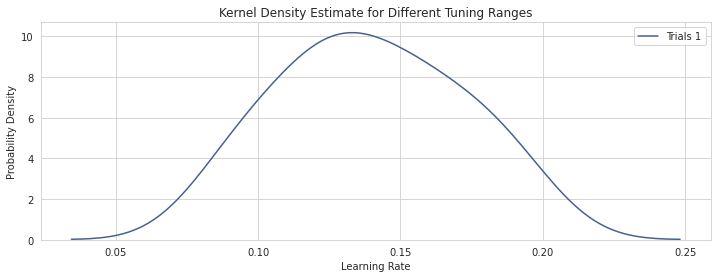

In [75]:
# plot kernel density estimates for number of boosting rounds
sns.kdeplot(trials_1_df['eta'], label='Trials 1')

plt.xlabel('Learning Rate')
plt.ylabel('Probability Density')

plt.title('Kernel Density Estimate for Different Tuning Ranges');

The chosen range is supporting a balanced distribution of hyperparameters.

I will observe the losses over the range of hyperparameters to notice the effects of different choices.

In [76]:
def plot_one_param(trials, param, param_min=None, param_max=None):
    """Plots MAEs vs. one hyperparameter with the option to limit the range"""
    df = make_trials_df(trials)
    # check to see if range needs to be altered
    if (param_min and param_max):
        df = df[(df[param] > param_min) & (df[param] < param_max)]        
    # plot hyperparameters for optimization run
    sns.regplot(x=param, y='loss', data=df, 
        scatter_kws={"s": 10}, label='Test Loss')

    plt.xlabel(param, fontsize=14)
    plt.ylabel('MAE', fontsize=14)
    
    plt.legend(bbox_to_anchor=(1.25, 0.5), loc=5, fontsize='x-large')

In [77]:
def plot_maes(trials):
    """Plots mean absolute errors for all hyperparameters"""
    # establish figure height
    num_subplots = len(trials.idxs)
    fig_height = num_subplots * 4
    # establish subplots
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot hyperparameters of optimization run
    count = 1
    # get all hyperparameters in trials object
    for key in trials.idxs:
        plt.subplot(num_subplots, 1, count)
        # call hyperparameter plotting function
        plot_one_param(trials, key)
        
        plt.xlabel(key, fontsize=14)
        plt.ylabel('MAE', fontsize=14)
        
        plt.legend(bbox_to_anchor=(1.25, 0.5), loc=5, fontsize='x-large')
        count += 1
        
    plt.suptitle('Hyperparameter Informed Search Results', y=0.93, fontsize=23);

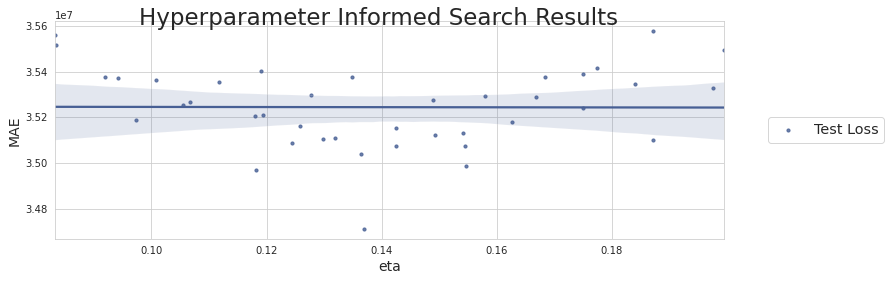

In [78]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_1)

The hybrid loss is constant throughout this range.<br>
Although the middle values appear to be the ones chosen by the best models, I will keep this search space for now.

The default value is 6.

 > **max_depth**

In [79]:
# get best hyperparameters from last trials
best_params = xgbr_trials_1.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'eta': [best_params['eta']],
    'max_depth': [int(x) for x in np.linspace(8, 22, num=8)],
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.13692436117600948]
max_depth [8, 10, 12, 14, 16, 18, 20, 22]


max_depth : 8 ...
Test MAE: $34,046,147.60
Training MAE: $11,841,271.90
Average Boosting Rounds: 405

max_depth : 10 ...
Test MAE: $33,597,868.60
Training MAE: $6,271,324.15
Average Boosting Rounds: 402

max_depth : 12 ...
Test MAE: $33,469,537.20
Training MAE: $3,585,933.23
Average Boosting Rounds: 378

max_depth : 14 ...
Test MAE: $33,326,664.00
Training MAE: $2,832,468.88
Average Boosting Rounds: 355

max_depth : 16 ...
Test MAE: $33,386,582.60
Training MAE: $810,362.43
Average Boosting Rounds: 379

max_depth : 18 ...
Test MAE: $32,991,632.80
Training MAE: $1,070,606.58
Average Boosting Rounds: 333

max_depth : 20 ...
Test MAE: $33,304,822.00
Training MAE: $1,067,281.29
Average Boosting Rounds: 315

max_depth : 22 ...
Test MAE: $33,158,183.80
Training MAE: $744,894.67
Average Boosting Rounds: 288



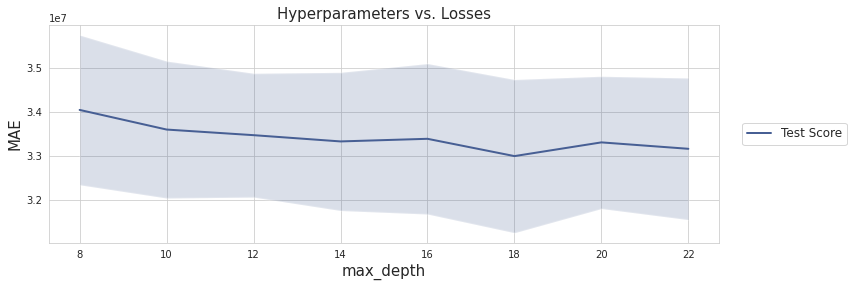

In [80]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [81]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_1)

Test MAE: $34,711,206.20
Training MAE: $19,149,182.80
Num Boosters: 436


The best choice for maximum tree depth is the default value of 6.<br>
I will set the range to be between 5 and 8, as those values give results that are not too far off from optimal.

 > **xgbr_trials_2**

In [82]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_2 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [83]:
# create informed search space  
hp_space = {
    'eta': hp.uniform('eta', 0.08, 0.2), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_2)
# save trials object
pickle.dump(xgbr_trials_2, open('./xgbr_trials/xgbr_trials_2.pkl', 'wb'))

100%|██████████| 20/20 [17:58<00:00, 53.93s/trial, best loss: 32994569.0] 


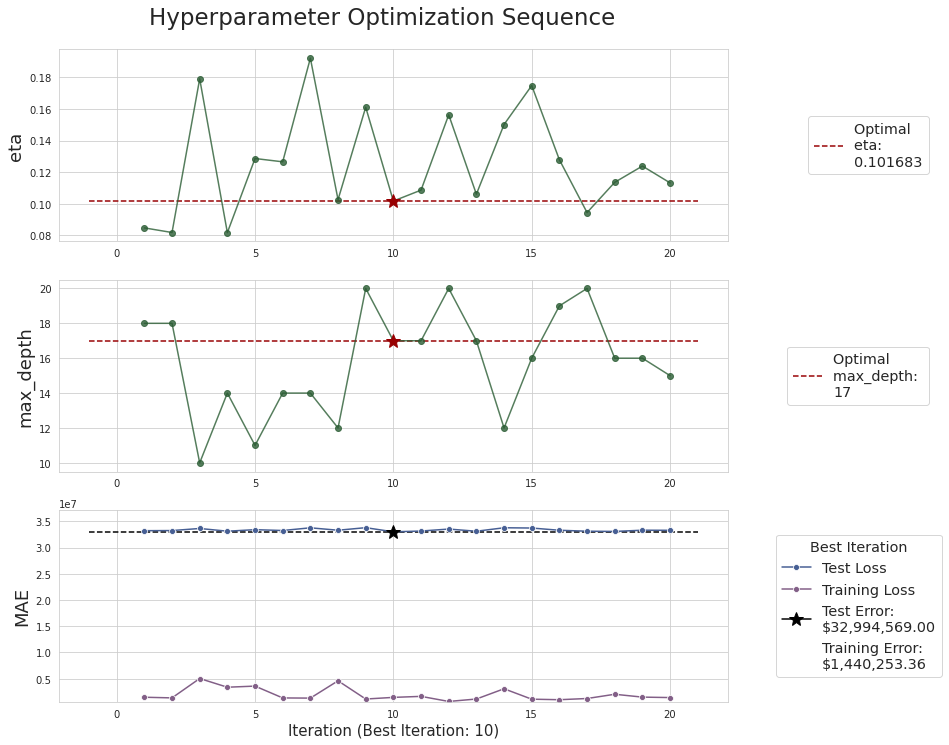

In [84]:
# plot informed search history
plot_param_search(xgbr_trials_2)

In [85]:
# get results DataFrame
trials_2_df = make_trials_df(xgbr_trials_2)
trials_2_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,eta,max_depth
9,1,1,10,32994569.0,1.440253e+06,402,0.101683,17
17,1,2,18,33068892.8,2.034877e+06,359,0.113538,16
12,1,2,13,33107276.8,1.129082e+06,404,0.106026,17
16,1,2,17,33113208.6,1.226335e+06,400,0.094390,20
3,1,1,4,33115579.2,3.378283e+06,464,0.081680,14
10,1,2,11,33146770.6,1.634443e+06,390,0.108600,17
0,1,1,1,33212102.4,1.467943e+06,464,0.084676,18
1,1,1,2,33236252.6,1.345051e+06,452,0.081751,18
5,1,1,6,33246489.0,1.335992e+06,424,0.126524,14
19,1,2,20,33283408.2,1.405005e+06,415,0.113195,15


In [86]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_1)

Test MAE: $34,711,206.20
Training MAE: $19,149,182.80
Num Boosters: 436


The values seem to be wide enough to allow exploration.

Although the scores ratio is not as good, the overall hybrid loss is decreasing.

In [87]:
def plot_kde(trials_dict):
    """Plot range of hyperparameters for each trial given"""
    # create empty dict to hold DataFrames of trials parameters
    df_dict = {}
    # fill dict with each DataFrame
    for trial, num in trials_dict.items():
        # create default dict to sort values of hyperparameters
        param_dict = defaultdict(list)
        # extract iterations
        for d in trial.miscs:
            # sort values from iteration
            for key, val in d['vals'].items():
                param_dict[key].append(val[0])
            # store sorted hyperparameter values from each trial in DataFrame
            param_df = pd.DataFrame(param_dict)
        # add DataFrame to dict
        df_dict[num] = param_df
    # get maximum number of hyperparameters to establish subplots
    n_rows = max([len(x.columns) for x in df_dict.values()])
    fig_height = n_rows * 4
    fig, axes = plt.subplots(nrows=n_rows, figsize=(12, fig_height))
    # create empty dict to map hyperparameters to axes numbers
    axes_dict = {}
    ax_num = -1
    # expand my color palette by looping it three times
    my_palette = ['xkcd:' + c for c in mp.my_colors] * 3
    # sort hyperparameters out of DataFrames
    for num, df in df_dict.items():
        # get list of hyperparameters from DataFrame
        cols_lst = list(df.columns)
        # go through hyperparameters and plot
        for param in cols_lst:
            # build axes mapper
            if param not in list(axes_dict.keys()):
                ax_num += 1
                axes_dict[param] = ax_num
            # plot kernel density estimate for hyperparameter
            g = sns.kdeplot(df[param], label=num, color=my_palette[num - 1], 
                        ax=axes[axes_dict[param]])
            g.set_xlabel(param, fontsize=15)
            g.set_ylabel('Probability Density', fontsize=15)

    plt.suptitle('Kernel Density Estimates for Different Tuning Ranges', fontsize=15)
    plt.subplots_adjust(top=0.95)

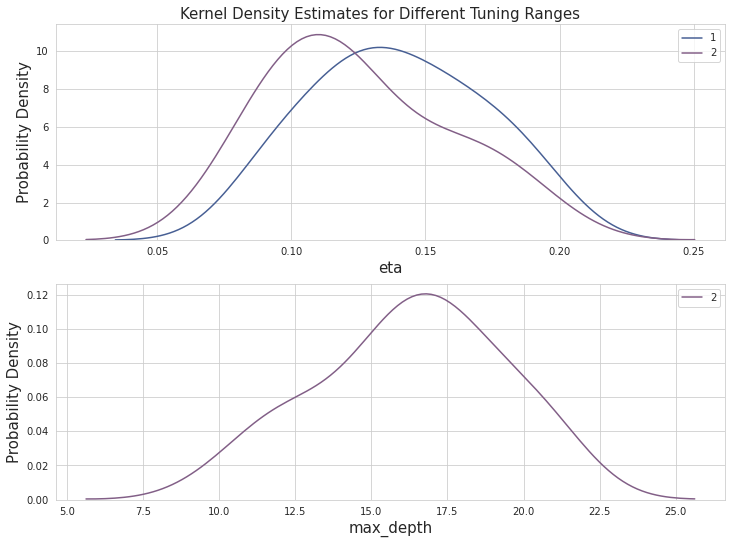

In [88]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2
        }
# plot the results, so far
plot_kde(_dict)

This search used less trees on average.

There are two local minima that were heavily searched with respect to the learning rate.

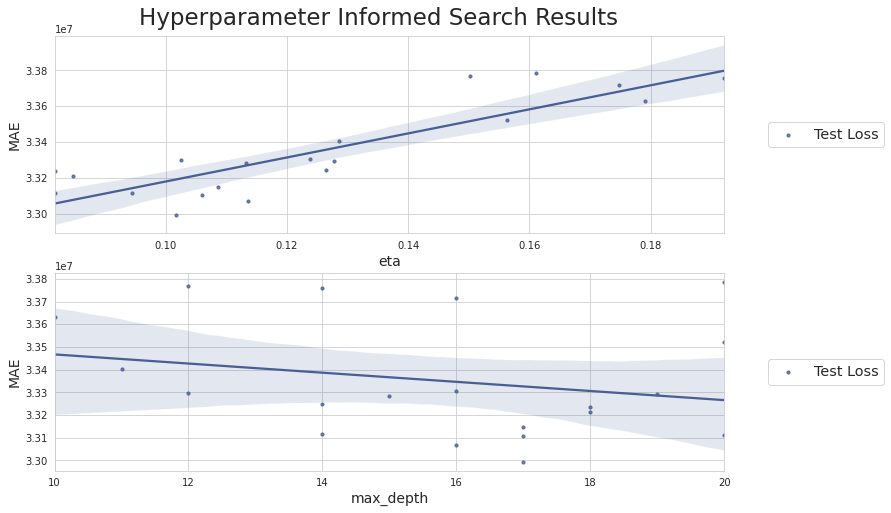

In [89]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_2)

 > **eta (retune)**

In [90]:
# get best hyperparameters from last trials
best_params = xgbr_trials_2.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'eta': np.linspace(0.03, 0.12, 10), 
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12]
max_depth [17]


eta : 0.03 ...
Test MAE: $33,674,555.00
Training MAE: $11,518,028.00
Average Boosting Rounds: 498

eta : 0.04 ...
Test MAE: $33,273,829.00
Training MAE: $7,462,812.00
Average Boosting Rounds: 496

eta : 0.05 ...
Test MAE: $32,801,293.80
Training MAE: $4,830,551.20
Average Boosting Rounds: 497

eta : 0.06 ...
Test MAE: $32,805,609.80
Training MAE: $2,969,168.33
Average Boosting Rounds: 497

eta : 0.07 ...
Test MAE: $33,226,133.00
Training MAE: $2,075,417.20
Average Boosting Rounds: 483

eta : 0.08 ...
Test MAE: $33,101,044.80
Training MAE: $1,510,046.16
Average Boosting Rounds: 473

eta : 0.09 ...
Test MAE: $32,938,059.40
Training MAE: $1,593,968.32
Average Boosting Rounds: 436

eta : 0.1 ...
Test MAE: $33,035,787.60
Training MAE: $1,673,962.61
Average Boosting Rounds: 413

eta : 0.11 ...
Test MAE: $33,284,730.00
Training MAE: $1,180,362.39
Average Boosting Rounds: 410

eta : 0.12 ...
Test MAE: $33,353,569.20
Training MAE: $1,232,599.62
Average Boosting Rounds: 393



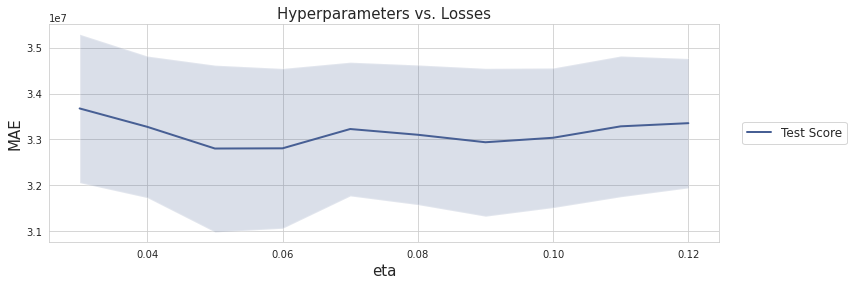

In [91]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [92]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_2)

Test MAE: $32,994,569.00
Training MAE: $1,440,253.36
Num Boosters: 402


 > **xgbr_trials_3**

In [93]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_3 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [94]:
# create informed search space  
hp_space = {
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3)
# save trials object
pickle.dump(xgbr_trials_3, open('./xgbr_trials/xgbr_trials_3.pkl', 'wb'))

100%|██████████| 40/40 [18:51<00:00, 28.30s/trial, best loss: 32492178.2] 


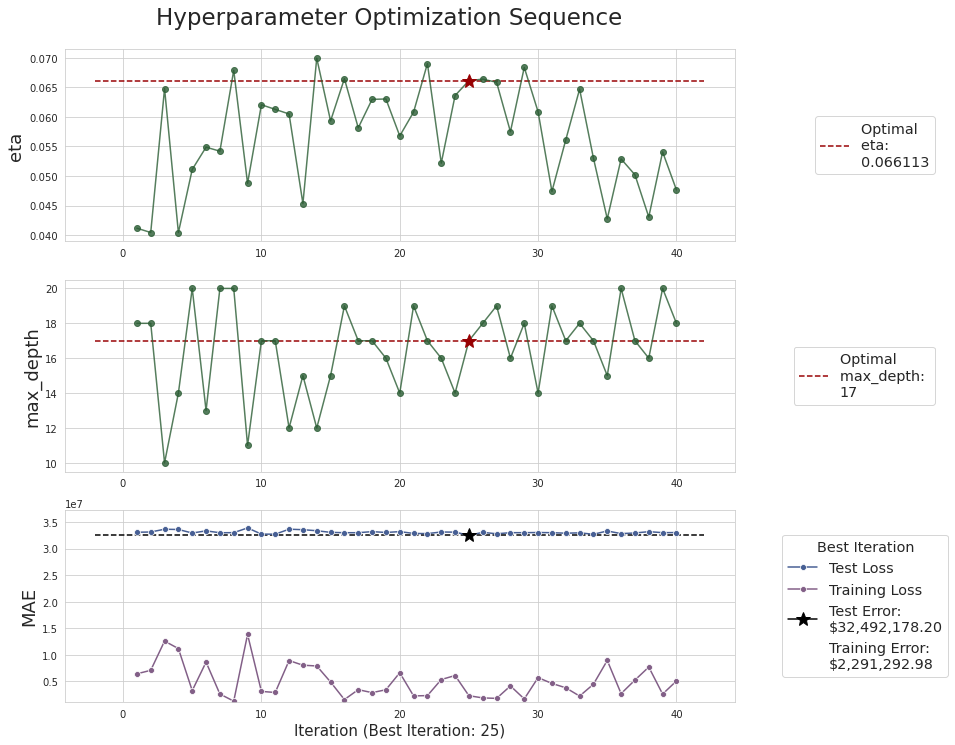

In [95]:
# plot informed search history
plot_param_search(xgbr_trials_3)

In [96]:
# get results DataFrame
trials_3_df = make_trials_df(xgbr_trials_3)
trials_3_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,eta,max_depth
24,1,3,25,32492178.2,2.291293e+06,487,0.066113,17
33,1,4,34,32681845.2,4.458859e+06,494,0.053009,17
10,1,2,11,32697065.2,2.901829e+06,492,0.061255,17
9,1,1,10,32709703.2,3.106126e+06,478,0.062042,17
26,1,3,27,32773216.4,1.791878e+06,479,0.065836,19
35,1,4,36,32804117.2,2.692844e+06,497,0.052877,20
21,1,3,22,32807299.6,2.314445e+06,473,0.068996,17
20,1,3,21,32835007.2,2.257840e+06,483,0.060799,19
31,1,4,32,32880425.4,3.788152e+06,493,0.056101,17
4,1,1,5,32915446.2,3.255543e+06,482,0.051099,20


In [101]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_2)

Test MAE: $32,994,569.00
Training MAE: $1,440,253.36
Num Boosters: 402


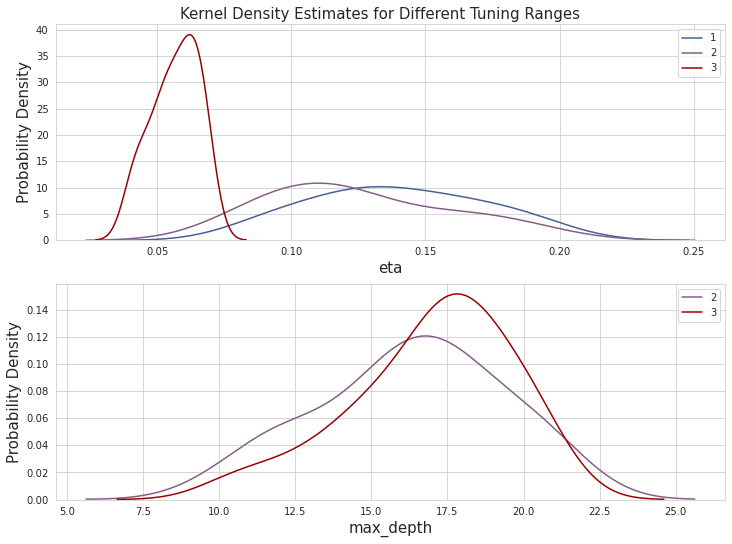

In [98]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2, 
         xgbr_trials_3: 3
        }
# plot the results, so far
plot_kde(_dict)

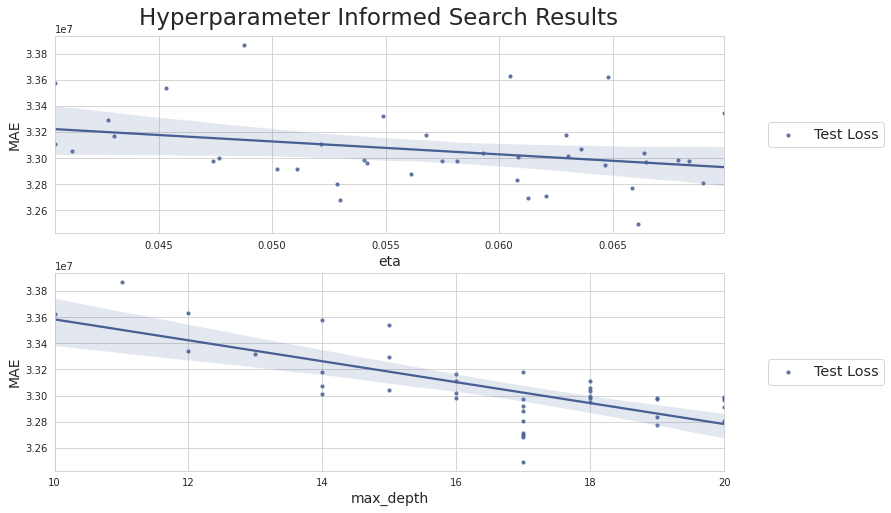

In [99]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_3)

 > **min_child_weight**

In [102]:
# get best hyperparameters from last trials
best_params = xgbr_trials_3.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']],
    'min_child_weight': [int(x) for x in np.linspace(1, 3, num=3)]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.06611282032366718]
max_depth [17]
min_child_weight [1, 2, 3]


min_child_weight : 1 ...
Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Average Boosting Rounds: 487

min_child_weight : 2 ...
Test MAE: $33,476,972.60
Training MAE: $8,243,899.40
Average Boosting Rounds: 464

min_child_weight : 3 ...
Test MAE: $34,043,464.60
Training MAE: $12,923,106.10
Average Boosting Rounds: 449



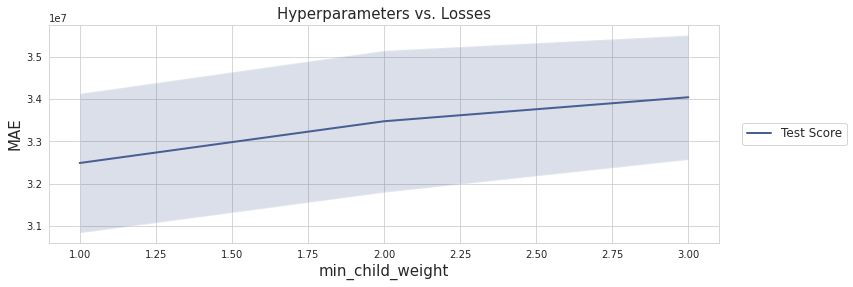

In [103]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [104]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


> **xgbr_trials_3a**

In [105]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_3a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [106]:
# create informed search space  
hp_space = {
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21)), 
    'min_child_weight': ho_scope.int(hp.uniform('min_child_weight', 1, 3))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3a)
# save trials object
pickle.dump(xgbr_trials_3a, open('./xgbr_trials/xgbr_trials_3a.pkl', 'wb'))

100%|██████████| 30/30 [18:30<00:00, 37.03s/trial, best loss: 32677886.4] 


In [107]:
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3a)
# save trials object
pickle.dump(xgbr_trials_3a, open('./xgbr_trials/xgbr_trials_3a.pkl', 'wb'))

100%|██████████| 40/40 [16:30<00:00, 24.77s/trial, best loss: 32677886.4] 


In [108]:
# get results DataFrame
trials_3a_df = make_trials_df(xgbr_trials_3a)
trials_3a_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,eta,max_depth,min_child_weight
12,1,2,13,32677886.4,2.734659e+06,473,0.063453,18,1
27,1,3,28,32735096.8,2.987657e+06,469,0.060822,18,1
4,1,1,5,32807171.6,3.865721e+06,479,0.048665,20,1
23,1,3,24,32833302.4,1.776556e+06,494,0.061028,20,1
2,1,1,3,32843513.2,3.794085e+06,499,0.048731,19,1
17,1,2,18,32871417.0,4.505399e+06,489,0.047154,19,1
13,1,2,14,32880960.6,2.674169e+06,480,0.065276,17,1
38,2,4,39,32900588.2,2.509634e+06,487,0.061813,18,1
20,1,3,21,32901218.8,1.478923e+06,476,0.067539,20,1
18,1,2,19,32907453.8,3.264480e+06,481,0.053840,19,1


In [109]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


The next hyperparameters to tune will be the max depth and the min child weight.<br>
Again, it is suggested to tune these two hyperparameters at the same time, as they influence each other.<br>
Child creation is performed greedily. The nodes want to be split, giving a tendency toward overfitting.<br>
If trees are not allowed to add more layers, the samples in each node become heavier.<br>
Likewise, if nodes are not allowed to split until they obtain a critical weight, model complexity will be constrained.<br>
Continuing with the physics nomenclature, I will observe a hypothetical parameter and call it the model's tree potential.

I will begin to tune these hypermarameters.<br>
Trees deeper than 6 layers tend to be strongly overfit.<br>
I'll begin my search with an upper bound of 8 on these values to allow for exploration, as local minima are discovered.

I'll continue with tuning the hyperparameter that limits the maximum number of levels the trees are allowed to grow.<br>
Recall, the default value is 3.

Once again, 3 is the optimal depth, but this may change as the other hyperparameters vary.

Again, the favoritism for the lower bounds by the learning rate and number of trees hyperparameters is obvious.<br>
I will make adjustments to them, now.

The range of tree depth looks suitable.

Looking at the larger values for the number of trees, there are large errors pulling the fitted hybrid line upward.<br>
I will observe what shrinking the upper bound of those values will yield.

 > **subsample**

In [110]:
# get best hyperparameters from last trials
best_params = xgbr_trials_3.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']],
    'subsample': np.linspace(0.9, 1, 6)
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.06611282032366718]
max_depth [17]
subsample [0.9  0.92 0.94 0.96 0.98 1.  ]


subsample : 0.9 ...
Test MAE: $32,847,200.80
Training MAE: $2,244,341.09
Average Boosting Rounds: 477

subsample : 0.92 ...
Test MAE: $32,863,221.60
Training MAE: $2,420,828.55
Average Boosting Rounds: 470

subsample : 0.9400000000000001 ...
Test MAE: $32,768,482.20
Training MAE: $2,028,381.89
Average Boosting Rounds: 491

subsample : 0.96 ...
Test MAE: $32,826,181.60
Training MAE: $2,024,730.04
Average Boosting Rounds: 495

subsample : 0.98 ...
Test MAE: $32,806,737.80
Training MAE: $2,929,397.64
Average Boosting Rounds: 456

subsample : 1.0 ...
Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Average Boosting Rounds: 487



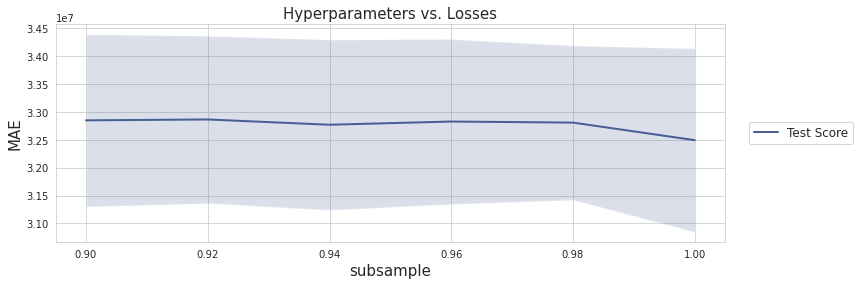

In [111]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [112]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


 > **xgbr_trials_3b**

In [113]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_3b = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [114]:
hp_space = {
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 20)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3b)
# save trials object
pickle.dump(xgbr_trials_3b, open('./xgbr_trials/xgbr_trials_3b.pkl', 'wb'))

100%|██████████| 20/20 [14:44<00:00, 44.22s/trial, best loss: 32705287.4]


In [115]:
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3b)
# save trials object
pickle.dump(xgbr_trials_3b, open('./xgbr_trials/xgbr_trials_3b.pkl', 'wb'))

100%|██████████| 50/50 [17:02<00:00, 20.45s/trial, best loss: 32581555.8] 


In [116]:
# get results DataFrame
trials_3b_df = make_trials_df(xgbr_trials_3b)
trials_3b_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,eta,max_depth,subsample
36,2,4,37,32581555.8,4508476.950,496,0.050366,17,0.981864
44,2,5,45,32610212.8,3235319.975,480,0.052852,19,0.985025
32,2,4,33,32650774.0,4545400.025,496,0.045950,18,0.967397
47,2,5,48,32655689.4,5060625.200,493,0.050963,16,0.982531
21,2,3,22,32677634.4,1454584.575,487,0.067502,19,0.942860
6,1,1,7,32705287.4,3993133.425,492,0.058356,15,0.935556
38,2,4,39,32707206.6,3729130.500,496,0.050076,18,0.974392
33,2,4,34,32721772.0,4598146.325,496,0.045665,18,0.970972
14,1,2,15,32722012.2,2929455.000,477,0.059829,17,0.943071
37,2,4,38,32726165.4,5101648.950,498,0.047075,17,0.981273


In [117]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


 > **colsample_bylevel**

In [118]:
# get best hyperparameters from last trials
best_params = xgbr_trials_3.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bylevel': np.linspace(0.5, 1.0, 6), 
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bylevel [0.5 0.6 0.7 0.8 0.9 1. ]
eta [0.06611282032366718]
max_depth [17]


colsample_bylevel : 0.5 ...
Test MAE: $32,926,829.80
Training MAE: $4,120,853.02
Average Boosting Rounds: 469

colsample_bylevel : 0.6 ...
Test MAE: $32,995,499.00
Training MAE: $3,614,582.83
Average Boosting Rounds: 468

colsample_bylevel : 0.7 ...
Test MAE: $32,682,870.60
Training MAE: $2,937,617.98
Average Boosting Rounds: 487

colsample_bylevel : 0.8 ...
Test MAE: $32,629,489.60
Training MAE: $3,193,584.98
Average Boosting Rounds: 476

colsample_bylevel : 0.9 ...
Test MAE: $33,040,303.60
Training MAE: $2,466,744.33
Average Boosting Rounds: 491

colsample_bylevel : 1.0 ...
Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Average Boosting Rounds: 487



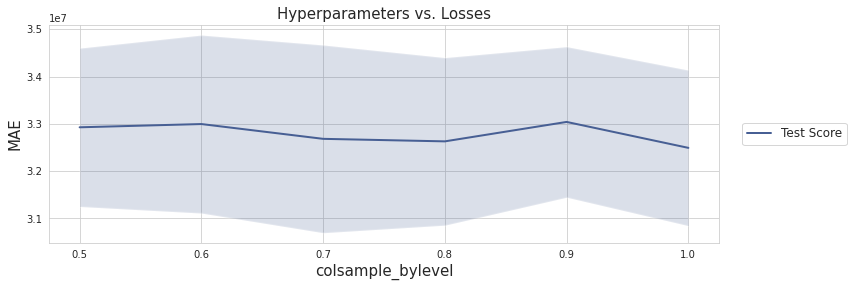

In [119]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [120]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


 > **xgbr_trials_3c**

In [121]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_3c = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [122]:
hp_space = {
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.6, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3c)
# save trials object
pickle.dump(xgbr_trials_3c, open('./xgbr_trials/xgbr_trials_3c.pkl', 'wb'))

100%|██████████| 30/30 [15:44<00:00, 31.48s/trial, best loss: 32541859.0] 


In [123]:
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3c)
# save trials object
pickle.dump(xgbr_trials_3c, open('./xgbr_trials/xgbr_trials_3c.pkl', 'wb'))

100%|██████████| 40/40 [17:37<00:00, 26.44s/trial, best loss: 32541859.0] 


In [124]:
# get results DataFrame
trials_3c_df = make_trials_df(xgbr_trials_3c)
trials_3c_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bylevel,eta,max_depth
13,1,2,14,32541859.0,2.211888e+06,487,0.779573,0.062083,20
17,1,2,18,32554036.2,3.213223e+06,467,0.638998,0.059168,20
10,1,2,11,32568715.0,2.748698e+06,492,0.662571,0.058690,20
31,2,4,32,32594993.4,3.397067e+06,476,0.744742,0.061246,18
33,2,4,34,32607630.6,2.793125e+06,489,0.702897,0.057622,20
24,1,3,25,32617266.2,2.635125e+06,498,0.763830,0.066110,17
32,2,4,33,32673776.4,1.562384e+06,490,0.965787,0.064764,20
29,1,3,30,32720717.4,5.554178e+06,496,0.798925,0.049680,17
7,1,1,8,32722538.0,5.320759e+06,498,0.933147,0.046052,18
18,1,2,19,32754205.6,3.277854e+06,495,0.738139,0.056048,19


With that adjustment, the learning rate is not struggling to find useful values as much.

In [125]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


The lower values of the learning rate tend to pay off more, though.

I will move on to sampling by features, as opposed to sampling by observations.<br>
There is really only one way to do these splits, that is, by level (at each depth of the tree).<br>
Splitting by node (at every split) has always produced the same results as splitting by level. So, I don't consider it.<br>
Also, splitting by tree (at the beginning) does not change the search results. So, that one will not be used, either.

I will move on to the stochastic hyperparameters.<br>
They all have default values of 1.

I will reduce the upper bound to 0.1 for the learning rate.

 > **colsample_bynode**

In [126]:
# get best hyperparameters from last trials
best_params = xgbr_trials_3.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bynode': np.linspace(0.7, 1.0, 4), 
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bynode [0.7 0.8 0.9 1. ]
eta [0.06611282032366718]
max_depth [17]


colsample_bynode : 0.7 ...
Test MAE: $33,040,961.40
Training MAE: $3,138,231.65
Average Boosting Rounds: 475

colsample_bynode : 0.7999999999999999 ...
Test MAE: $32,784,778.60
Training MAE: $2,816,401.80
Average Boosting Rounds: 483

colsample_bynode : 0.9 ...
Test MAE: $32,675,666.20
Training MAE: $2,780,135.35
Average Boosting Rounds: 481

colsample_bynode : 1.0 ...
Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Average Boosting Rounds: 487



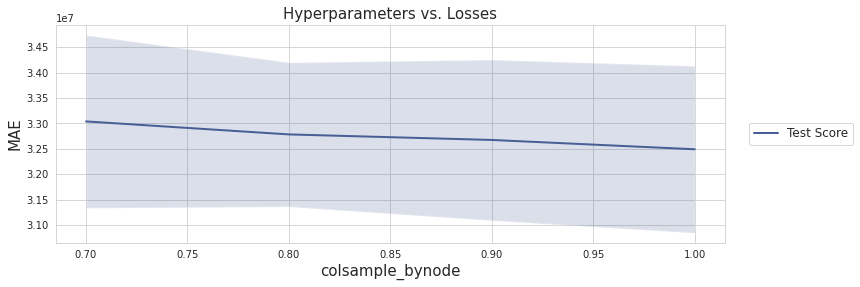

In [127]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [128]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


 > **xgbr_trials_4**

In [129]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_4 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [130]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_4)
# save trials object
pickle.dump(xgbr_trials_4, open('./xgbr_trials/xgbr_trials_4.pkl', 'wb'))

100%|██████████| 20/20 [25:04<00:00, 75.23s/trial, best loss: 32483288.4] 


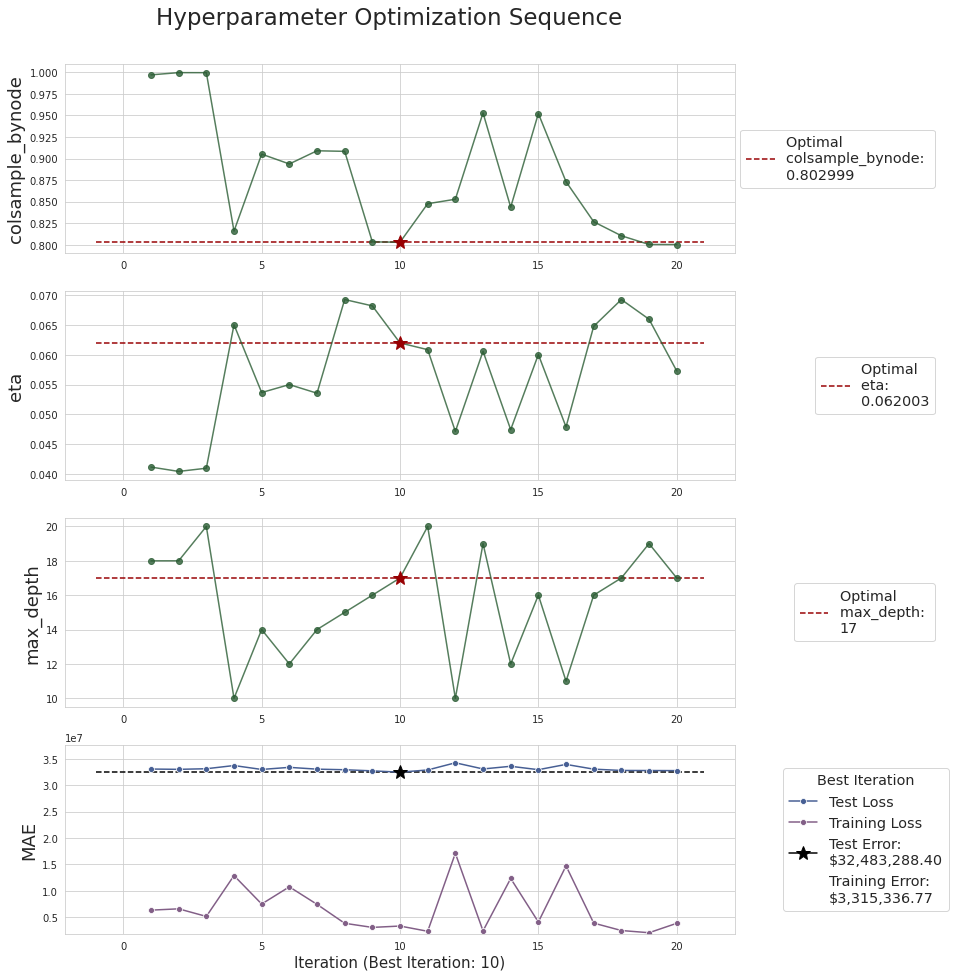

In [131]:
# plot informed search history
plot_param_search(xgbr_trials_4)

In [132]:
# get results DataFrame
trials_4_df = make_trials_df(xgbr_trials_4)
trials_4_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bynode,eta,max_depth
9,1,1,10,32483288.4,3.315337e+06,482,0.802999,0.062003,17
8,1,1,9,32728606.4,3.055882e+06,484,0.803391,0.068222,16
19,1,2,20,32777325.6,3.832676e+06,494,0.800319,0.057305,17
18,1,2,19,32791564.8,2.048678e+06,478,0.800377,0.065981,19
17,1,2,18,32806579.6,2.465624e+06,482,0.810495,0.069287,17
10,1,2,11,32897968.8,2.320908e+06,476,0.847666,0.060874,20
7,1,1,8,32941667.8,3.836856e+06,469,0.908412,0.069289,15
14,1,2,15,32952102.2,4.077703e+06,483,0.952245,0.060053,16
4,1,1,5,32997889.2,7.487623e+06,494,0.905189,0.053677,14
1,1,1,2,33018312.8,6.577335e+06,495,0.999713,0.040438,18


In [133]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


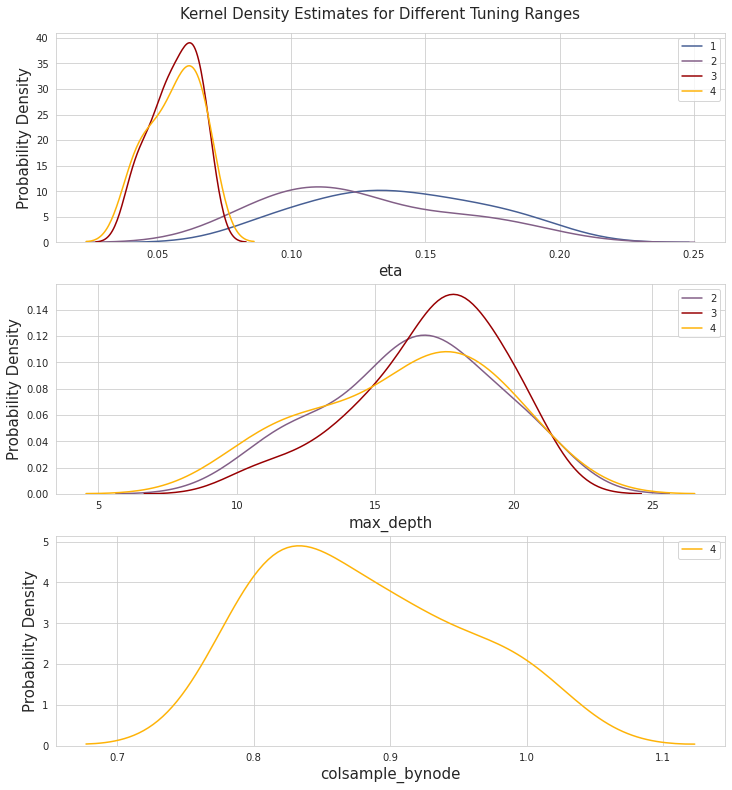

In [134]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2, 
         xgbr_trials_3: 3, 
         xgbr_trials_4: 4
        }
# plot the results, so far
plot_kde(_dict)

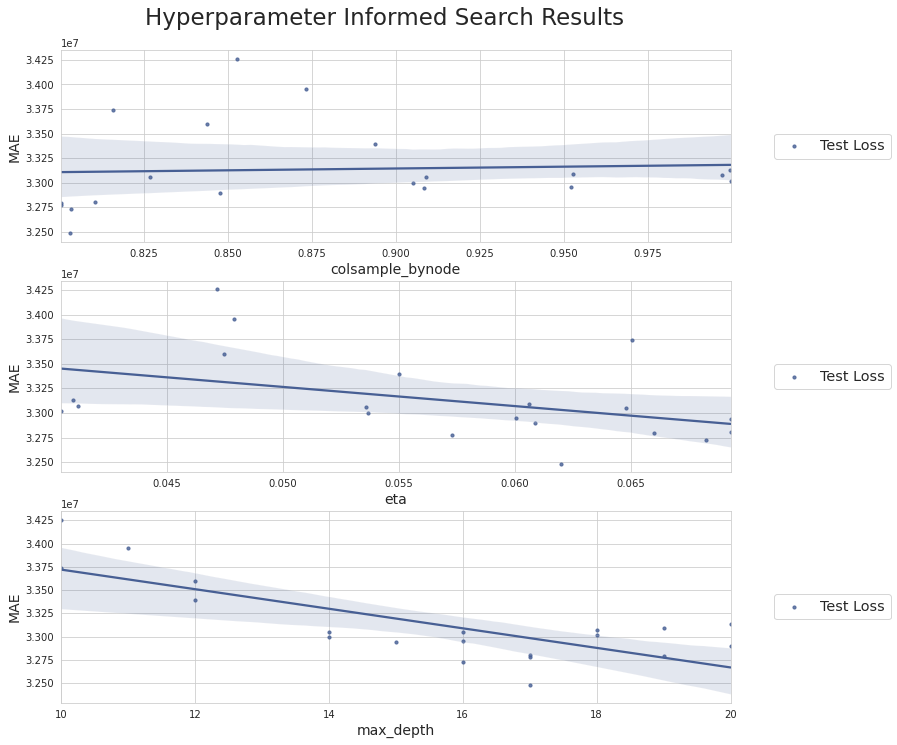

In [135]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_4)

 > **colsample_bytree**

In [136]:
# get best hyperparameters from last trials
best_params = xgbr_trials_4.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bytree': np.linspace(0.5, 1.0, 6), 
    'colsample_bynode': [best_params['colsample_bynode']],
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bytree [0.5 0.6 0.7 0.8 0.9 1. ]
colsample_bynode [0.8029987229679669]
eta [0.06200339576094763]
max_depth [17]


colsample_bytree : 0.5 ...
Test MAE: $33,244,497.00
Training MAE: $5,153,077.90
Average Boosting Rounds: 497

colsample_bytree : 0.6 ...
Test MAE: $32,995,869.80
Training MAE: $4,780,786.28
Average Boosting Rounds: 494

colsample_bytree : 0.7 ...
Test MAE: $32,936,118.60
Training MAE: $4,458,663.80
Average Boosting Rounds: 495

colsample_bytree : 0.8 ...
Test MAE: $33,116,922.60
Training MAE: $4,366,156.75
Average Boosting Rounds: 485

colsample_bytree : 0.9 ...
Test MAE: $32,940,904.20
Training MAE: $3,388,221.88
Average Boosting Rounds: 497

colsample_bytree : 1.0 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482



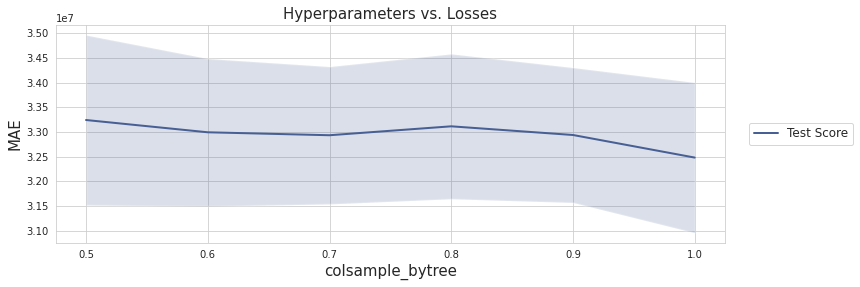

In [137]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [189]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Test MAE: $32,492,178.20
Training MAE: $2,291,292.98
Num Boosters: 487


 > **xgbr_trials_4a**

In [138]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_4a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [139]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.9, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_4a)
# save trials object
pickle.dump(xgbr_trials_4a, open('./xgbr_trials/xgbr_trials_4a.pkl', 'wb'))

100%|██████████| 20/20 [23:25<00:00, 70.28s/trial, best loss: 32616429.6] 


In [140]:
# get results DataFrame
trials_4a_df = make_trials_df(xgbr_trials_4a)
trials_4a_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bynode,colsample_bytree,eta,max_depth
9,1,1,10,32616429.6,5.688169e+06,496,0.853717,0.977009,0.048223,17
6,1,1,7,32708146.6,2.825489e+06,499,0.800377,0.960353,0.054187,20
14,1,2,15,32748660.2,2.850534e+06,494,0.887502,0.905726,0.058567,19
12,1,2,13,32827986.6,4.664172e+06,490,0.855679,0.981538,0.061928,15
19,1,2,20,32834087.0,6.966813e+06,493,0.801915,0.953174,0.044153,17
4,1,1,5,32838268.6,3.257394e+06,492,0.923020,0.967681,0.051099,20
7,1,1,8,32854541.4,2.183667e+06,453,0.801473,0.917750,0.069799,20
18,1,2,19,32876779.8,5.110918e+06,497,0.824594,0.969422,0.050492,17
17,1,2,18,32921000.8,2.833743e+06,496,0.825065,0.957962,0.054741,20
13,1,2,14,32931586.2,8.525220e+06,496,0.827253,0.942882,0.045548,15


In [141]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


 > **alpha**

In [142]:
# get best hyperparameters from last trials
best_params = xgbr_trials_4.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'alpha': np.linspace(0, 0.05, 6),
    'colsample_bynode': [best_params['colsample_bynode']], 
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']],
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

alpha [0.   0.01 0.02 0.03 0.04 0.05]
colsample_bynode [0.8029987229679669]
eta [0.06200339576094763]
max_depth [17]


alpha : 0.0 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482

alpha : 0.01 ...
Test MAE: $32,840,657.00
Training MAE: $3,848,538.77
Average Boosting Rounds: 486

alpha : 0.02 ...
Test MAE: $32,763,003.60
Training MAE: $3,934,202.77
Average Boosting Rounds: 495

alpha : 0.03 ...
Test MAE: $32,944,620.60
Training MAE: $4,373,174.75
Average Boosting Rounds: 497

alpha : 0.04 ...
Test MAE: $32,823,521.40
Training MAE: $4,926,015.70
Average Boosting Rounds: 491

alpha : 0.05 ...
Test MAE: $33,018,016.00
Training MAE: $5,187,503.10
Average Boosting Rounds: 493



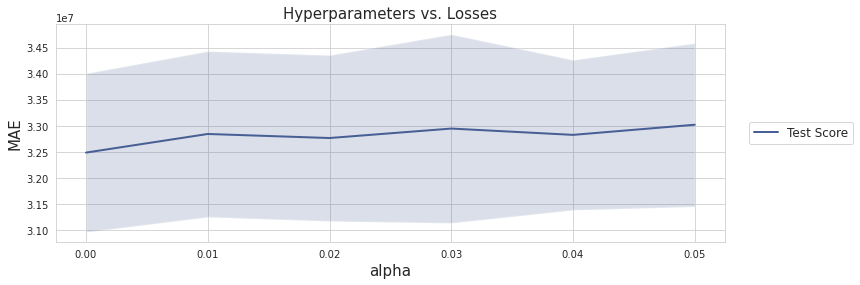

In [143]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [144]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


 > **xgbr_trials_4b**

In [145]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_4b = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [146]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.03), 
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_4b)
# save trials object
pickle.dump(xgbr_trials_4b, open('./xgbr_trials/xgbr_trials_4b.pkl', 'wb'))

100%|██████████| 20/20 [27:40<00:00, 83.01s/trial, best loss: 32704964.0] 


In [147]:
# get results DataFrame
trials_4b_df = make_trials_df(xgbr_trials_4b)
trials_4b_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,alpha,colsample_bynode,eta,max_depth
6,1,1,7,32704964.0,1.475472e+06,492,0.000810,0.816598,0.068038,20
17,1,2,18,32705771.0,1.766499e+06,472,0.001210,0.802956,0.069831,20
7,1,1,8,32707391.6,1.699005e+06,471,0.000105,0.801473,0.069419,20
19,1,2,20,32791025.6,2.750165e+06,491,0.003586,0.825555,0.056867,20
18,1,2,19,32822407.0,4.100373e+06,472,0.004712,0.800334,0.066198,16
12,1,2,13,32875954.8,4.626398e+06,498,0.012032,0.881977,0.047130,20
14,1,2,15,33001145.8,2.794260e+06,473,0.010066,0.958844,0.064430,19
16,1,2,17,33030949.8,3.728476e+06,444,0.017275,0.913040,0.068004,19
1,1,1,2,33039208.6,7.547083e+06,498,0.029732,0.999713,0.040438,18
11,1,2,12,33044623.4,5.679084e+06,492,0.004876,0.856607,0.049389,17


In [148]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


 > **lambda**

In [149]:
# get best hyperparameters from last trials
best_params = xgbr_trials_4.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'lambda': np.linspace(0.2, 1.6, 8),
    'colsample_bynode': [best_params['colsample_bynode']], 
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']],
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

lambda [0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6]
colsample_bynode [0.8029987229679669]
eta [0.06200339576094763]
max_depth [17]


lambda : 0.2 ...
Test MAE: $32,970,361.00
Training MAE: $2,081,261.30
Average Boosting Rounds: 444

lambda : 0.4 ...
Test MAE: $33,033,520.80
Training MAE: $1,865,391.70
Average Boosting Rounds: 482

lambda : 0.6000000000000001 ...
Test MAE: $33,157,328.00
Training MAE: $2,320,747.85
Average Boosting Rounds: 483

lambda : 0.8 ...
Test MAE: $32,960,023.80
Training MAE: $2,676,459.30
Average Boosting Rounds: 488

lambda : 1.0 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482

lambda : 1.2 ...
Test MAE: $32,895,233.00
Training MAE: $3,386,360.48
Average Boosting Rounds: 498

lambda : 1.4000000000000001 ...
Test MAE: $32,666,016.00
Training MAE: $4,040,401.12
Average Boosting Rounds: 493

lambda : 1.6 ...
Test MAE: $32,713,970.60
Training MAE: $4,671,682.35
Average Boosting Rounds: 486



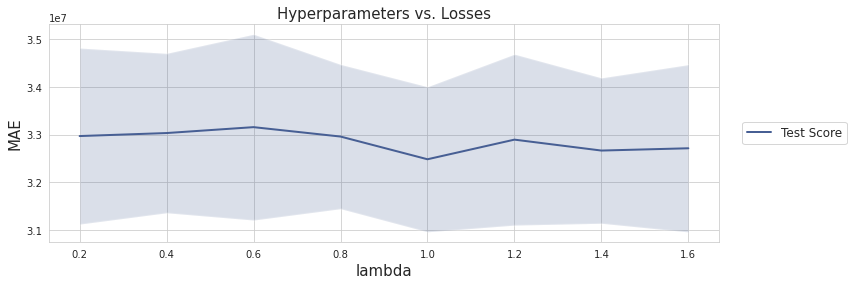

In [150]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [151]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


 > **xgbr_trials_4c**

In [152]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_4c = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [153]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'lambda': hp.uniform('lambda', 0.2, 1.5), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_4c)
# save trials object
pickle.dump(xgbr_trials_4c, open('./xgbr_trials/xgbr_trials_4c.pkl', 'wb'))

100%|██████████| 50/50 [17:50<00:00, 21.40s/trial, best loss: 32553161.8] 


In [154]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


 > **gamma**

In [155]:
# get best hyperparameters from last trials
best_params = xgbr_trials_4.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bynode': [best_params['colsample_bynode']], 
    'eta': [best_params['eta']],
    'gamma': [0.1, 1, 10, 100, 1000],
    'max_depth': [best_params['max_depth']],
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bynode [0.8029987229679669]
eta [0.06200339576094763]
gamma [0.1, 1, 10, 100, 1000]
max_depth [17]


gamma : 0.1 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482

gamma : 1 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482

gamma : 10 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482

gamma : 100 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482

gamma : 1000 ...
Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Average Boosting Rounds: 482



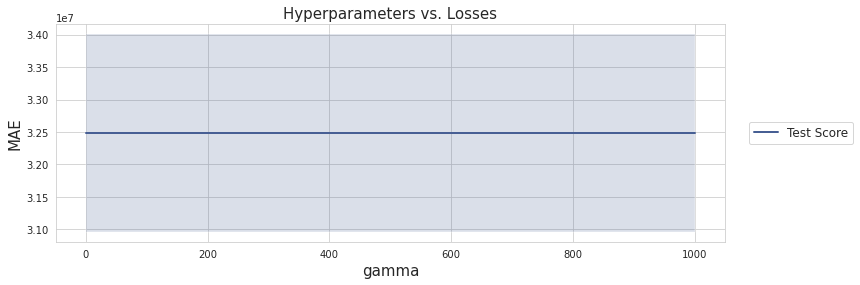

In [156]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [157]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


 > **max_delta_step**

In [158]:
# get best hyperparameters from last trials
best_params = xgbr_trials_4.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bynode': [best_params['colsample_bynode']], 
    'eta': [best_params['eta']],
    'max_delta_step': np.linspace(0.9, 1.9, 6),
    'max_depth': [best_params['max_depth']],
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bynode [0.8029987229679669]
eta [0.06200339576094763]
max_delta_step [0.9 1.1 1.3 1.5 1.7 1.9]
max_depth [17]


max_delta_step : 0.9 ...
Test MAE: $32,617,662.00
Training MAE: $10,026,210.10
Average Boosting Rounds: 497

max_delta_step : 1.1 ...
Test MAE: $32,342,058.80
Training MAE: $7,737,427.90
Average Boosting Rounds: 496

max_delta_step : 1.3 ...
Test MAE: $32,397,262.00
Training MAE: $6,311,312.65
Average Boosting Rounds: 499

max_delta_step : 1.5 ...
Test MAE: $32,356,094.40
Training MAE: $5,777,133.30
Average Boosting Rounds: 492

max_delta_step : 1.7 ...
Test MAE: $32,360,188.00
Training MAE: $5,132,884.90
Average Boosting Rounds: 498

max_delta_step : 1.9 ...
Test MAE: $32,596,780.20
Training MAE: $4,807,187.40
Average Boosting Rounds: 498



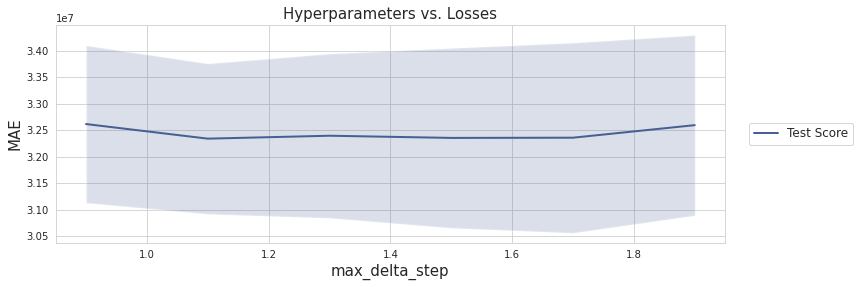

In [159]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [160]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


 > **xgbr_trials_5**

In [161]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_5 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [162]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_delta_step': hp.uniform('max_delta_step', 0.9, 1.9), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_5)
# save trials object
pickle.dump(xgbr_trials_5, open('./xgbr_trials/xgbr_trials_5.pkl', 'wb'))

100%|██████████| 20/20 [20:04<00:00, 60.23s/trial, best loss: 31912026.6] 


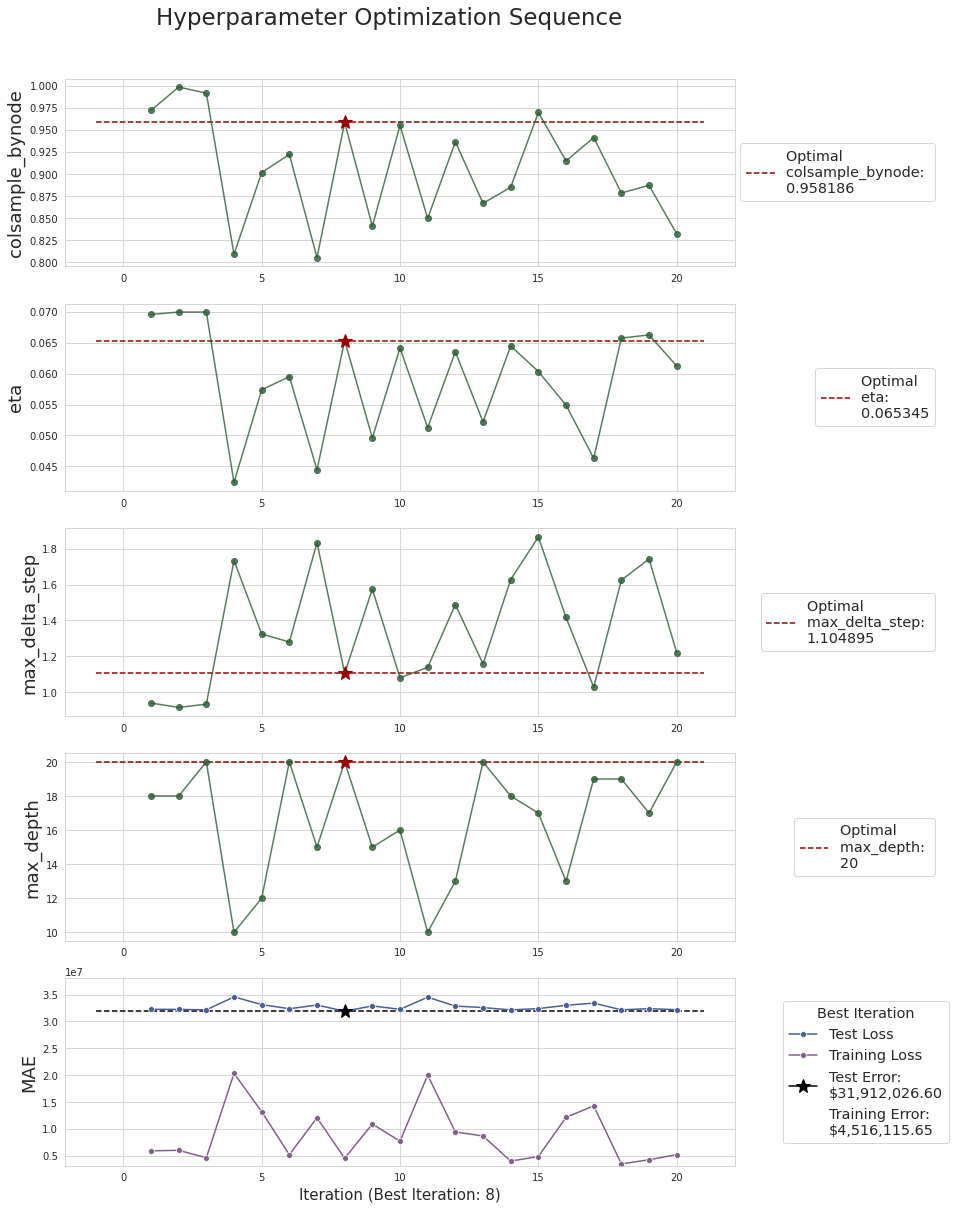

In [163]:
# plot informed search history
plot_param_search(xgbr_trials_5)

In [164]:
# get results DataFrame
trials_5_df = make_trials_df(xgbr_trials_5)
trials_5_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bynode,eta,max_delta_step,max_depth
7,1,1,8,31912026.6,4516115.650,496,0.958186,0.065345,1.104895,20
13,1,2,14,32151591.2,3995970.025,494,0.884897,0.064477,1.628700,18
17,1,2,18,32163953.6,3458149.325,492,0.878472,0.065757,1.625931,19
2,1,1,3,32166364.2,4610015.650,498,0.991444,0.069951,0.932457,20
19,1,2,20,32184444.6,5197457.100,498,0.832249,0.061229,1.220573,20
1,1,1,2,32237986.6,5996991.650,496,0.998212,0.069957,0.914589,18
9,1,1,10,32263621.2,7702878.150,497,0.954918,0.064139,1.080290,16
0,1,1,1,32264094.6,5899638.950,495,0.971885,0.069569,0.938970,18
5,1,1,6,32364937.6,5188144.200,496,0.922039,0.059511,1.279807,20
18,1,2,19,32387102.2,4232820.350,487,0.887050,0.066251,1.743254,17


In [165]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Test MAE: $32,483,288.40
Training MAE: $3,315,336.77
Num Boosters: 482


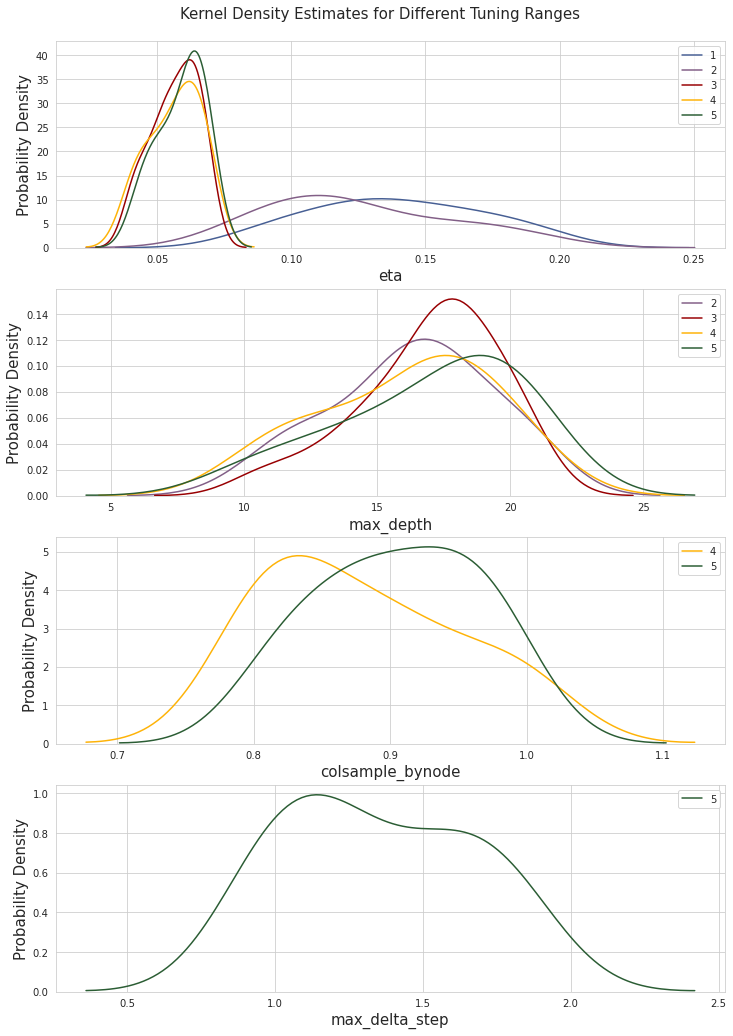

In [166]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2, 
         xgbr_trials_3: 3, 
         xgbr_trials_4: 4, 
         xgbr_trials_5: 5
        }
# plot the results, so far
plot_kde(_dict)

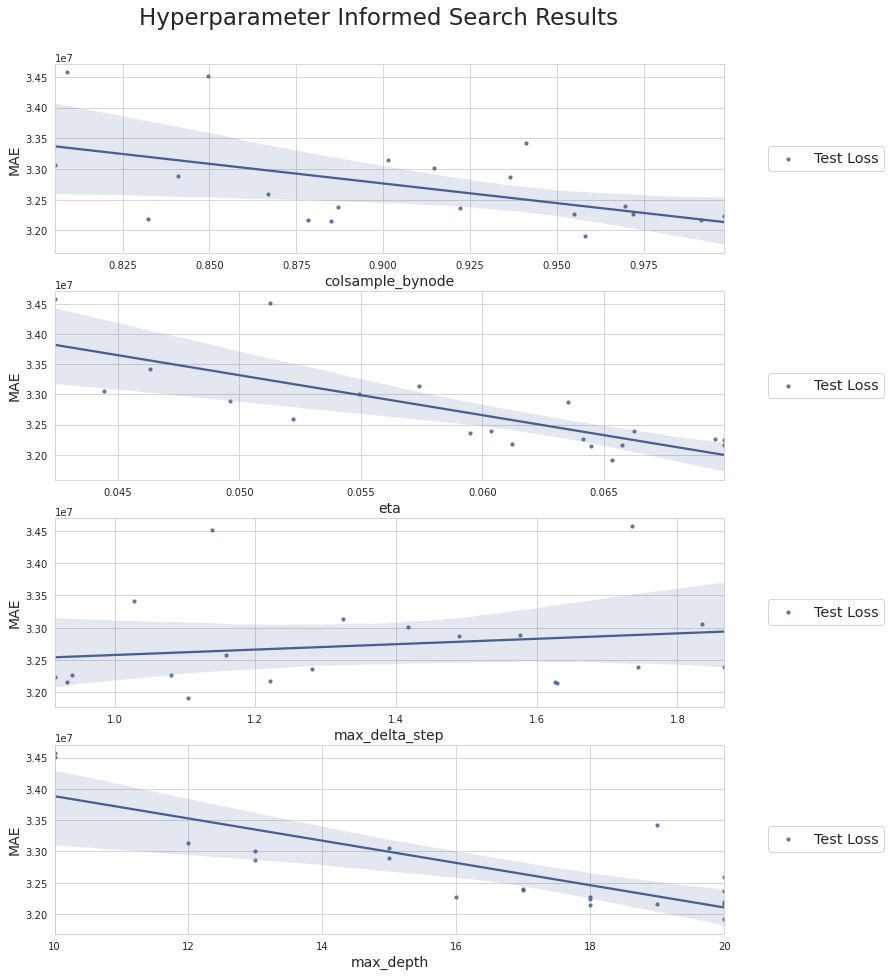

In [167]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_5)

 > **eta (retune)**

In [168]:
# get best hyperparameters from last trials
best_params = xgbr_trials_5.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bynode': [best_params['colsample_bynode']], 
    'eta': np.linspace(0.04, 0.14, 6),
    'max_delta_step': [best_params['max_delta_step']],
    'max_depth': [best_params['max_depth']],
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bynode [0.95818635507785]
eta [0.04 0.06 0.08 0.1  0.12 0.14]
max_delta_step [1.1048948126486449]
max_depth [20]


eta : 0.04 ...
Test MAE: $34,732,845.60
Training MAE: $19,038,730.20
Average Boosting Rounds: 500

eta : 0.06 ...
Test MAE: $32,468,936.80
Training MAE: $6,141,643.00
Average Boosting Rounds: 498

eta : 0.08 ...
Test MAE: $32,209,677.60
Training MAE: $2,282,067.59
Average Boosting Rounds: 487

eta : 0.1 ...
Test MAE: $32,123,574.60
Training MAE: $1,218,279.87
Average Boosting Rounds: 460

eta : 0.12 ...
Test MAE: $32,351,809.00
Training MAE: $1,289,848.18
Average Boosting Rounds: 408

eta : 0.14 ...
Test MAE: $32,677,668.60
Training MAE: $1,041,685.21
Average Boosting Rounds: 374



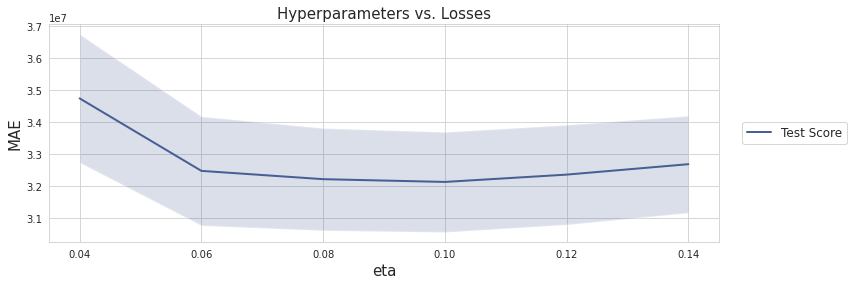

In [169]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [170]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_5)

Test MAE: $31,912,026.60
Training MAE: $4,516,115.65
Num Boosters: 496


 > **xgbr_trials_5a**

In [171]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_5a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [172]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.04, 0.14), 
    'max_delta_step': hp.uniform('max_delta_step', 0.9, 1.9), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_5a)
# save trials object
pickle.dump(xgbr_trials_5a, open('./xgbr_trials/xgbr_trials_5a.pkl', 'wb'))

100%|██████████| 20/20 [23:31<00:00, 70.59s/trial, best loss: 31940454.8] 


In [173]:
# get results DataFrame
trials_5a_df = make_trials_df(xgbr_trials_5a)
trials_5a_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bynode,eta,max_delta_step,max_depth
8,1,1,9,31940454.8,3.841057e+06,498,0.874681,0.068328,1.597309,17
18,1,2,19,32069764.2,2.387300e+06,466,0.974069,0.081385,1.667097,18
16,1,2,17,32146402.8,1.617126e+06,454,0.949565,0.095741,1.493277,17
19,1,2,20,32154220.6,1.662022e+06,489,0.905542,0.079638,1.647465,19
17,1,2,18,32239071.2,1.427946e+06,479,0.945361,0.093598,1.470099,17
10,1,2,11,32288608.6,2.982213e+06,495,0.841978,0.075339,1.552600,17
1,1,1,2,32303023.4,1.148809e+06,399,0.998212,0.139857,0.914589,18
4,1,1,5,32374342.0,3.342044e+06,487,0.891020,0.092594,1.355915,14
5,1,1,6,32383463.2,1.597429e+06,485,0.922039,0.105057,1.288295,15
2,1,1,3,32401675.8,7.177092e+05,406,0.991444,0.139836,0.932457,20


In [174]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_5)

Test MAE: $31,912,026.60
Training MAE: $4,516,115.65
Num Boosters: 496


 > **xgbr_trials_5b**

In [175]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_5b = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [176]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.06, 0.14), 
    'max_delta_step': hp.uniform('max_delta_step', 0.9, 1.9), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_5b)
# save trials object
pickle.dump(xgbr_trials_5b, open('./xgbr_trials/xgbr_trials_5b.pkl', 'wb'))

100%|██████████| 30/30 [25:41<00:00, 51.37s/trial, best loss: 31960054.2] 


In [177]:
# get results DataFrame
trials_5b_df = make_trials_df(xgbr_trials_5b)
trials_5b_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bynode,eta,max_delta_step,max_depth
17,1,2,18,31960054.2,7.094581e+05,486,0.837144,0.103063,1.207251,20
19,1,2,20,32064627.6,2.740235e+06,494,0.868006,0.075739,1.193854,19
26,1,3,27,32082251.4,2.217317e+06,483,0.912550,0.086609,1.115792,18
23,1,3,24,32108459.8,6.633316e+06,497,0.886426,0.069901,1.023923,16
14,1,2,15,32122051.4,2.267601e+06,483,0.843569,0.079747,1.250256,20
25,1,3,26,32122368.4,2.552323e+06,497,0.827159,0.072168,1.339476,20
18,1,2,19,32145154.6,1.087421e+06,425,0.825797,0.111967,1.274025,19
29,1,3,30,32162605.6,1.968086e+06,462,0.895864,0.115382,0.972786,15
24,1,3,25,32173429.4,7.655447e+05,487,0.860991,0.094820,1.498607,20
20,1,3,21,32184546.8,2.590681e+06,478,0.876426,0.096152,1.039208,16


In [184]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_5)

Test MAE: $31,912,026.60
Training MAE: $4,516,115.65
Num Boosters: 496


CAN GET RID OF ALL DART

 > **DART**

 > **xgbr_trials_5c**

In [178]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_5c = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [179]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_delta_step': hp.uniform('max_delta_step', 0.9, 1.9), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_5c, 
                  booster='dart')
# save trials object
pickle.dump(xgbr_trials_5c, open('./xgbr_trials/xgbr_trials_5c.pkl', 'wb'))

100%|██████████| 30/30 [44:02<00:00, 88.07s/trial, best loss: 31986460.2] 


In [180]:
# get results DataFrame
trials_5c_df = make_trials_df(xgbr_trials_5c)
trials_5c_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bynode,eta,max_delta_step,max_depth
13,1,2,14,31986460.2,4667642.550,495,0.920535,0.064001,1.243457,19
0,1,1,1,32123253.0,5877097.850,496,0.971885,0.069569,0.938970,18
21,1,3,22,32158067.8,5377475.800,497,0.887670,0.062749,1.188131,19
19,1,2,20,32254214.0,5280355.100,494,0.940514,0.060917,1.201138,20
28,1,3,29,32259459.0,5800857.800,498,0.865861,0.069170,0.949604,18
1,1,1,2,32274559.2,5914795.700,498,0.998212,0.069957,0.914589,18
17,1,2,18,32280937.8,5335460.700,496,0.944635,0.067900,0.984622,19
22,1,3,23,32295866.8,4938799.950,498,0.967415,0.067030,1.396022,16
14,1,2,15,32306505.8,4544791.600,494,0.915831,0.063232,1.323946,19
18,1,2,19,32307154.4,4209717.425,495,0.983449,0.067293,1.467375,17


In [181]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_5)

Test MAE: $31,912,026.60
Training MAE: $4,516,115.65
Num Boosters: 496


DON'T USE DART. GET RID OF THIS ONE

 > **xgbr_trials_5d**

In [185]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_5d = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [186]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_delta_step': hp.uniform('max_delta_step', 0.9, 1.9), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21)), 
    'one_drop': ho_scope.int(hp.choice('one_drop', [0, 1])),
    'rate_drop': hp.uniform('rate_drop', 0, 1.0),
    'skip_drop': hp.uniform('skip_drop', 0, 1.0)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_5d, 
                  booster='dart')
# save trials object
pickle.dump(xgbr_trials_5d, open('./xgbr_trials/xgbr_trials_5d.pkl', 'wb'))

100%|██████████| 40/40 [31:53<00:00, 47.84s/trial, best loss: 32441265.4] 


In [187]:
# get results DataFrame
trials_5d_df = make_trials_df(xgbr_trials_5d)
trials_5d_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bynode,eta,max_delta_step,max_depth,one_drop,rate_drop,skip_drop
27,1,3,28,32441265.4,6398664.25,495,0.835339,0.057534,1.556462,19,0,0.310181,0.921289
33,1,4,34,32456004.2,7173125.85,498,0.835868,0.050222,1.552134,20,1,0.950351,0.992582
34,1,4,35,32550169.6,8370689.95,498,0.845267,0.053341,1.454517,17,1,0.965099,0.991571
31,1,4,32,32661327.8,8027902.35,498,0.879828,0.049593,1.565779,20,1,0.575776,0.931462
24,1,3,25,32681925.4,6635534.70,497,0.879690,0.057236,1.622588,18,0,0.341789,0.927198
21,1,3,22,32832683.0,9513631.10,498,0.957102,0.061701,1.767980,14,0,0.352993,0.880107
23,1,3,24,32849356.8,10518500.00,496,0.957627,0.058651,1.617831,14,0,0.332214,0.915856
20,1,3,21,32915214.6,10154436.20,496,0.964612,0.059845,1.729468,14,0,0.100440,0.862681
19,1,2,20,33104594.2,17609790.50,496,0.966301,0.060950,1.772408,13,0,0.113227,0.850790
18,1,2,19,33140749.0,31605372.40,498,0.972560,0.056081,1.736294,13,0,0.126624,0.846364


In [188]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_5)

Test MAE: $31,912,026.60
Training MAE: $4,516,115.65
Num Boosters: 496


In [191]:
def get_param_range(trials_lst, loss_thresh):
    """Returns DataFrame with range of hyperparameters from best models of trials"""
    # create empty objects to hold sorted values
    param_dict = defaultdict(list)
    param_range_dict = defaultdict(list)
    best_models_lst = []
    # roll through trial objects
    for trial in trials_lst:
        # get each model from trial object
        for model in trial:
            # sort models by performance
            if (model['result']['loss'] < loss_thresh):
                # extract desired models
                best_models_lst.append(model)
        # roll through best models
        for best_model in best_models_lst:
            # extract hyperparameter values of desired models
            for param, val in best_model['result']['params'].items():
                param_dict[param].append(val)
    # roll through each hyperparameter
    for hp, val_lst in param_dict.items():
        # filter out operational params
        if hp not in ['booster', 'disable_default_eval_metric', 'tree_method']:
            # extract range of hyperparameter values for all best models in trails objects
            param_range_dict[hp].append((np.min(val_lst), np.max(val_lst)))
        
    return pd.DataFrame(param_range_dict)

In [193]:
# assemble desired trial runs
_lst = [xgbr_trials_5, 
        xgbr_trials_5a, 
        xgbr_trials_5b
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 3.2e7)

,colsample_bynode,eta,max_delta_step,max_depth
0,"(0.8371442107913502, 0.95818635507785)","(0.06534522748755471, 0.103062777833581)","(1.1048948126486449, 1.5973092257226076)","(17, 20)"


In [192]:
# assemble desired trial runs
_lst = [xgbr_trials_5, 
        xgbr_trials_5a, 
        xgbr_trials_5b, 
        xgbr_trials_5c
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 3.2e7)

,colsample_bynode,eta,max_delta_step,max_depth
0,"(0.8371442107913502, 0.95818635507785)","(0.06400134454350799, 0.103062777833581)","(1.1048948126486449, 1.5973092257226076)","(17, 20)"


 > **xgbr_trials_6**

In [197]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_6 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [198]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.83, 0.96), 
    'eta': hp.uniform('eta', 0.06, 0.11), 
    'max_delta_step': hp.uniform('max_delta_step', 1.1, 1.6), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 17, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_6)
# save trials object
pickle.dump(xgbr_trials_6, open('./xgbr_trials/xgbr_trials_6.pkl', 'wb'))

100%|██████████| 30/30 [26:32<00:00, 53.09s/trial, best loss: 31964301.6] 


In [199]:
# get results DataFrame
trials_6_df = make_trials_df(xgbr_trials_6)
trials_6_df.head(10)

,trial,batch,iteration,loss,train_mae,n_boost,colsample_bynode,eta,max_delta_step,max_depth
17,1,2,18,31964301.6,2.245212e+06,485,0.898851,0.085926,1.104318,18
12,1,2,13,32017233.2,3.356972e+06,485,0.859988,0.080723,1.125163,17
25,1,3,26,32065825.4,2.622695e+06,488,0.871698,0.086389,1.102125,17
23,1,3,24,32091518.0,1.340234e+06,493,0.886995,0.095166,1.162337,18
2,1,1,3,32092919.6,9.287432e+05,438,0.954439,0.109918,1.116228,20
22,1,3,23,32100930.6,1.580658e+06,493,0.906962,0.088455,1.106796,19
16,1,2,17,32102284.2,3.556801e+06,487,0.846779,0.073024,1.176633,19
18,1,2,19,32111465.6,2.059614e+06,495,0.895803,0.085259,1.141108,18
21,1,3,22,32117538.6,3.769950e+06,497,0.850761,0.074558,1.237116,17
20,1,3,21,32120612.8,2.090899e+06,493,0.878341,0.084093,1.161183,18


In [195]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_5)

Test MAE: $31,912,026.60
Training MAE: $4,516,115.65
Num Boosters: 496


In [ ]:
f

In [ ]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_6)

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_6 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1), 
    'eta': hp.uniform('eta', 0.04, 0.07), 
    'max_delta_step': hp.uniform('max_delta_step', 0.9, 1.9), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21))
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_6, 
                  booster='dart')
# save trials object
pickle.dump(xgbr_trials_6, open('./xgbr_trials/xgbr_trials_6.pkl', 'wb'))

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_5)

In [ ]:
# get results DataFrame
trials_6_df = make_trials_df(xgbr_trials_6)
trials_6_df.head(10)

In [ ]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_6)

In [ ]:
#xgbr_trials_4 = pickle.load(open('./xgbr_trials/xgbr_trials_4b.pkl', 'rb'))

 > **colsample_bytree**

In [ ]:
# get best hyperparameters from last trials
best_params = xgbr_trials_6.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bylevel': [best_params['colsample_bylevel']], 
    'colsample_bytree': np.linspace(0.2, 1.0, 9), 
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']],
    'subsample': [best_params['subsample']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

In [ ]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 10, get_scratch_cv, 'gpu_hist', param_grid)

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_6)

 > **xgbr_trials_7**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_7 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 3, 9)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7)
# save trials object
pickle.dump(xgbr_trials_7, open('./xgbr_trials/xgbr_trials_7.pkl', 'wb'))

In [ ]:
# plot informed search history
plot_param_search(xgbr_trials_7)

In [ ]:
# get results DataFrame
trials_7_df = make_trials_df(xgbr_trials_7)
trials_7_df.head(10)

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_6)

In [ ]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2, 
         xgbr_trials_3: 3, 
         xgbr_trials_4: 4, 
         xgbr_trials_5: 5, 
         xgbr_trials_6: 6, 
         xgbr_trials_7: 7
        }
# plot the results, so far
plot_kde(_dict)

In [ ]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_7)

Three models had improved hybrid losses, with alphas of 0.02, 0.06, and 0.09.<br>
This implies that local minima are scattered throughout the alpha search space.<br>
I'll set the range to start at the default value and let it increase up to 0.1.

 > **xgbr_trials_7a**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_7a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.1), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 3, 9)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7a)
# save trials object
pickle.dump(xgbr_trials_7a, open('./xgbr_trials/xgbr_trials_7a.pkl', 'wb'))

In [ ]:
# get results DataFrame
trials_7a_df = make_trials_df(xgbr_trials_7a)
trials_7a_df.head(10)

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_7)

The search space where the local minima were found are constrained.<br>
I will narrow some of the broad ranges of the other hyperparameters to lessen the number of values to choose.

In [ ]:
best_params

From the number of features selected on the model to beat, I see that the range for both samplings can be above 70%.

 > **xgbr_trials_7b**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_7b = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.1), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.7, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 3, 9)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7b)
# save trials object
pickle.dump(xgbr_trials_7b, open('./xgbr_trials/xgbr_trials_7b.pkl', 'wb'))

In [ ]:
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7b)
# save trials object
pickle.dump(xgbr_trials_7b, open('./xgbr_trials/xgbr_trials_7b.pkl', 'wb'))

In [ ]:
# get results DataFrame
trials_7b_df = make_trials_df(xgbr_trials_7b)
trials_7b_df.head(10)

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_7)

The informed search has not, yet, found any of the local minima that I observed while running the last grid search.

In [ ]:
best_params

I will narrow the range of tree depth to remove move values from the search space.

 > **xgbr_trials_7c**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_7c = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.1), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.7, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 7)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7c)
# save trials object
pickle.dump(xgbr_trials_7c, open('./xgbr_trials/xgbr_trials_7c.pkl', 'wb'))

In [ ]:
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7c)
# save trials object
pickle.dump(xgbr_trials_7c, open('./xgbr_trials/xgbr_trials_7c.pkl', 'wb'))

In [ ]:
# get results DataFrame
trials_7c_df = make_trials_df(xgbr_trials_7c)
trials_7c_df.head(10)

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_7)

The results are getting better.<br>
Shrinking the range of tree depth has narrowed the optimal feature search space.<br>
I will constrain that range a little more.

 > **xgbr_trials_7d**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_7d = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.1), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.8, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 7)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7d)
# save trials object
pickle.dump(xgbr_trials_7d, open('./xgbr_trials/xgbr_trials_7d.pkl', 'wb'))

In [ ]:
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7d)
# save trials object
pickle.dump(xgbr_trials_7d, open('./xgbr_trials/xgbr_trials_7d.pkl', 'wb'))

In [ ]:
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7d)
# save trials object
pickle.dump(xgbr_trials_7d, open('./xgbr_trials/xgbr_trials_7d.pkl', 'wb'))

In [ ]:
# get results DataFrame
trials_7d_df = make_trials_df(xgbr_trials_7d)
trials_7d_df.head(10)

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_7)

The hybrid loss is almost to where it was when I observed the local minima during the grid search.<br>
I will narrow the range of alpha values to only include those near one of those local minima.<br>
The best models are choosing the lowest values for alpha,<br>
So, I will search near the smallest minimum, where alpha is 0.02.

 > **xgbr_trials_8**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_8 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.03), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.8, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 7)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_8)
# save trials object
pickle.dump(xgbr_trials_8, open('./xgbr_trials/xgbr_trials_8.pkl', 'wb'))

In [ ]:
# plot informed search history
plot_param_search(xgbr_trials_8)

In [ ]:
# get results DataFrame
trials_8_df = make_trials_df(xgbr_trials_8)
trials_8_df.head(10)

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_7)

In [ ]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2, 
         xgbr_trials_3: 3, 
         xgbr_trials_4: 4, 
         xgbr_trials_5: 5, 
         xgbr_trials_6: 6, 
         xgbr_trials_7: 7, 
         xgbr_trials_8: 8
        }
# plot the results, so far
plot_kde(_dict)

In [ ]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_8)

 > **xgbr_trials_8a**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_8a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.03), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.8, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1), 
    'eta': hp.uniform('eta', 0.03, 0.12), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 7)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_8a)
# save trials object
pickle.dump(xgbr_trials_8a, open('./xgbr_trials/xgbr_trials_8a.pkl', 'wb'))

In [ ]:
# get results DataFrame
trials_8a_df = make_trials_df(xgbr_trials_8a)
trials_8a_df.head(10)

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_8)

In [ ]:
def get_param_range(trials_lst, loss_thresh, ratio_thresh):
    """Returns DataFrame with range of hyperparameters from best models of trials"""
    # create empty objects to hold sorted values
    param_dict = defaultdict(list)
    param_range_dict = defaultdict(list)
    best_models_lst = []
    # roll through trial objects
    for trial in trials_lst:
        # get each model from trial object
        for model in trial:
            # sort models by performance
            if (model['result']['loss'] < loss_thresh
               ) & (model['result']['scores_ratio'] > ratio_thresh):
                # extract desired models
                best_models_lst.append(model)
        # roll through best models
        for best_model in best_models_lst:
            # extract hyperparameter values of desired models
            for param, val in best_model['result']['params'].items():
                param_dict[param].append(val)
    # roll through each hyperparameter
    for hp, val_lst in param_dict.items():
        # filter out operational params
        if hp not in ['booster', 'disable_default_eval_metric', 'tree_method']:
            # extract range of hyperparameter values for all best models in trails objects
            param_range_dict[hp].append((np.min(val_lst), np.max(val_lst)))
        
    return pd.DataFrame(param_range_dict)

In [ ]:
# assemble desired trial runs
_lst = [xgbr_trials_7, 
        xgbr_trials_8, 
        xgbr_trials_8a
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 4.16e7, 0.94)

 > **xgbr_trials_8b**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_8b = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.03), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.76, 0.84), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.79, 1), 
    'eta': hp.uniform('eta', 0.085, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 6)), 
    'subsample': hp.uniform('subsample', 0.93, 0.98)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_8b)
# save trials object
pickle.dump(xgbr_trials_8b, open('./xgbr_trials/xgbr_trials_8b.pkl', 'wb'))

In [ ]:
# get results DataFrame
trials_8b_df = make_trials_df(xgbr_trials_8b)
trials_8b_df.head(10)

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_8)

In [ ]:
# assemble desired trial runs
_lst = [xgbr_trials_8, 
        xgbr_trials_8b
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 4.16e7, 0.95)

 > **xgbr_trials_8c**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_8c = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'alpha': hp.uniform('alpha', 0.008, 0.0084), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.76, 0.81), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.99, 1), 
    'eta': hp.uniform('eta', 0.1, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 4.1)), 
    'subsample': hp.uniform('subsample', 0.97, 0.98)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_8c)
# save trials object
pickle.dump(xgbr_trials_8c, open('./xgbr_trials/xgbr_trials_8c.pkl', 'wb'))

In [ ]:
# get results DataFrame
trials_8c_df = make_trials_df(xgbr_trials_8c)
trials_8c_df.head(10)

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_8)

In [ ]:
# assemble desired trial runs
_lst = [xgbr_trials_8, 
        xgbr_trials_8c
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 4.16e7, 0.95)

 > **xgbr_trials_9**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_9 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'alpha': hp.uniform('alpha', 0.0083, 0.0084), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.79, 0.81), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.99, 1), 
    'eta': hp.uniform('eta', 0.1, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 4.1)), 
    'subsample': hp.uniform('subsample', 0.97, 0.98)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_9)
# save trials object
pickle.dump(xgbr_trials_9, open('./xgbr_trials/xgbr_trials_9.pkl', 'wb'))

In [ ]:
# get results DataFrame
trials_9_df = make_trials_df(xgbr_trials_9)
trials_9_df.head(10)

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_8)

 > **xgbr_trials_9a**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_9a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
# create informed search space using a single default value
hp_space = {
    'alpha': hp.choice(
        'alpha', [0.09, 
                  0.09]), 
    'colsample_bylevel': hp.choice(
        'colsample_bylevel', [best_params['colsample_bylevel'], 
                              best_params['colsample_bylevel']]), 
    'colsample_bytree': hp.choice(
        'colsample_bytree', [best_params['colsample_bytree'], 
                             best_params['colsample_bytree']]), 
    'eta': hp.choice(
        'eta', [best_params['eta'], 
                best_params['eta']]), 
    'max_depth': hp.choice(
        'max_depth', [best_params['max_depth'], 
                      best_params['max_depth']]), 
    'subsample': hp.choice(
        'subsample', [best_params['subsample'], 
                      best_params['subsample']])
}
# call optimization function
fmin_objective = partial(objective, features=X_train, target=y_train, 
                         delta=2e2, cv_type=get_scratch_cv, 
                         processor_type='gpu_hist', max_boost_round=500)
fmin(fn=fmin_objective, space=hp_space, max_evals=1, trials=xgbr_trials_9a, 
     algo=tpe.suggest, rstate=np.random.RandomState(27))

# save trials object
pickle.dump(xgbr_trials_9a, open('./xgbr_trials/xgbr_trials_9a.pkl', 'wb'))

In [ ]:
# get results DataFrame
trials_9a_df = make_trials_df(xgbr_trials_9a)
trials_9a_df

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_9)

In [ ]:
# observe metrics of best sample from previous grid search
print_best_trial(xgbr_trials_9a)

In [ ]:
# assemble desired trial runs
_lst = [xgbr_trials_9, 
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 4.154e7, 0.95)

 > **xgbr_trials_10**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_10 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'alpha': hp.uniform('alpha', 0.00833, 0.00835), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.794, 0.798), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.993, 0.997), 
    'eta': hp.uniform('eta', 0.107, 0.108), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 4.1)), 
    'subsample': hp.uniform('subsample', 0.971, 0.973)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_10)
# save trials object
pickle.dump(xgbr_trials_10, open('./xgbr_trials/xgbr_trials_10.pkl', 'wb'))

In [ ]:
# get results DataFrame
trials_10_df = make_trials_df(xgbr_trials_10)
trials_10_df.head(10)

In [ ]:
# observe metrics of best sample from previous grid search
print_best_trial(xgbr_trials_9a)

In [ ]:
# assemble desired trial runs
_lst = [xgbr_trials_10, 
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 4.153e7, 0.95)

 > **xgbr_trials_10a**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_10a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'alpha': hp.uniform('alpha', 0.00834, 0.00835), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.796, 0.798), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.993, 0.995), 
    'eta': hp.uniform('eta', 0.107, 0.108), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 4.1)), 
    'subsample': hp.uniform('subsample', 0.971, 0.972)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_10a)
# save trials object
pickle.dump(xgbr_trials_10a, open('./xgbr_trials/xgbr_trials_10a.pkl', 'wb'))

In [ ]:
# get results DataFrame
trials_10a_df = make_trials_df(xgbr_trials_10a)
trials_10a_df.head(10)

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_10)

In [ ]:
# assemble desired trial runs
_lst = [xgbr_trials_10, 
        xgbr_trials_10a, 
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 4.15e7, 0.95)

 > **xgbr_trials_10b**

In [ ]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_10b = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [ ]:
hp_space = {
    'alpha': hp.uniform('alpha', 0.00834, 0.00835), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.797, 0.798), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.993, 0.994), 
    'eta': hp.uniform('eta', 0.107, 0.108), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 4.1)), 
    'subsample': hp.uniform('subsample', 0.971, 0.972)
}
# call optimization function
run_trial_batches(X_train, y_train, 10, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_10b)
# save trials object
pickle.dump(xgbr_trials_10b, open('./xgbr_trials/xgbr_trials_10b.pkl', 'wb'))

In [ ]:
# get results DataFrame
trials_10b_df = make_trials_df(xgbr_trials_10b)
trials_10b_df.head(10)

In [ ]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_10)

In [ ]:
def join_losses(trials_dict):
    """Extracts losses and hyperparameters for best estimator of each trials object"""
    # specify columns to extract
    loss_cols = ['loss', 'training_scores', 'test_scores', 'scores_ratio']
    # instantiate empty DataFrame
    df = pd.DataFrame()
    # iterate through trials objects
    for key, value in trials_dict.items():
        # extract metrics
        loss_df = pd.DataFrame(
            key.best_trial['result'], index=[value], columns=loss_cols)
        # extract parameters for best estimator of each trial session
        params_df = pd.DataFrame(
            key.best_trial['result']['params'], index=[value])
        # put it all together
        trials_df = loss_df.join(params_df)
        df = pd.concat([df, trials_df])
        df.reset_index()
        
    return df

In [ ]:
def plot_metrics(trials_dict):
    """Plot loss metrics and ratio of training and test losses for best ensembles"""
    # establish subplots
    fig, axes = plt.subplots(nrows=2, figsize=(12, 9))
    # construct DataFrame
    df = join_losses(trials_dict)
    # plot loss metrics
    plt.subplot(2, 1, 1)
    sns.lineplot(x=df.index, y='loss', data=df, label='Hybrid Loss')
    sns.lineplot(x=df.index, y='test_scores', data=df, label='Test Loss')
    sns.lineplot(x=df.index, y='training_scores', data=df, label='Training Loss')
    
    plt.ylabel('MAE', fontsize=15)

    plt.legend()
    plt.title('Mean Absolute Errors for Best Ensamble of Each Trial')
    # plot training test loss ratio
    plt.subplot(2, 1, 2)
    sns.lineplot(x=df.index, y='scores_ratio', data=df)
    
    plt.xlabel('Trials', fontsize=15)
    plt.ylabel('Training to Test Loss Ratio', fontsize=15)

In [ ]:
# assemble all trial runs
trials_dict = {xgbr_trials_0: 0, 
               xgbr_trials_1: 1, 
               xgbr_trials_2: 2, 
               xgbr_trials_3: 3, 
               xgbr_trials_4: 4, 
               xgbr_trials_5: 5, 
               xgbr_trials_6: 6, 
               xgbr_trials_7: 7, 
               xgbr_trials_8: 8, 
               xgbr_trials_10: 9, 
               xgbr_trials_10: 10
              }
# plot the results
plot_metrics(trials_dict)

All of the top 10 models chose a node weight value of 1, as expected.

The first sampling method I will adjust is the percent of observations to use at each round.

 > **reg_lambda**

Ridge regularization penalizes the larger errors to prevent overfitting.<br>
Recall, the default value is 0, which means no regularization.

Looking at these plots, it is obvious that the minimization of the overfitting is the main goal for this method.<br>
All of the average MAE lines are way higher than the ones produces by the previous trials.

Now, I believe this is as far as I can traditionally tune the hyperparameters, but I have one more card to play.<br>
I'm going to cherry pick the ranges of hyperparameters from trials 12 and 13, the last two before the detour.<br>
This will squeze the search into a tight area I know is fruitful to see if I can hunt for lower ground.<br>
After extensively searching for a good local minimum, I'm settling down into it to see if I've found its true bottom.<br>
As I mentioned before the sidetrack, I will put the number of trees back to 250.

 > **XGBoost Final Evaluation**

While evaluating the final model on the validation data, I'd, also, like to know how well my unorthodox strategy worked.

First, I'll see what the error of base model would have been, without any hyperparameter tuning.

In [ ]:
def print_validation_results(X, y, trials=None, params={}):
    """Print final validation error & percent difference between training and validation"""
    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=27)
    # get hyperparameters from trials object
    if trials:
        params = trials.best_trial['result']['params']
    # get errors
    train_results = get_scratch_cv(X_train, y_train, 2e2, 'gpu_hist', params=params)
    test_results = get_scratch_cv(X_test, y_test, 2e2, 'gpu_hist', params=params)
    # average score over folds
    train_mae = np.mean(train_results['test_mae'])
    test_mae = np.mean(test_results['test_mae'])
    # get fractional difference between training and test errors
    frac_diff = (test_mae - train_mae) / test_mae
    
    print('Training Error: {}\nValidation Error: {}\nPercent Difference: {:,.2f}%'.format(
        make_money(train_mae), make_money(test_mae), frac_diff * 100))

In [ ]:
# get validation results without tuning
print_validation_results(X, y)

The base model's error is nearly 14% worse on the validation set than it was on the training data.

Next, I'll find out how the model with the best test score did on the validation set.<br>
Recall, the test score was the first part of my hybrid loss function.<br>
This is the loss value that's the standard one to optimize.

In [ ]:
# create DataFrame with all trials
trials_df = join_losses(trials_dict)
trials_df

In [ ]:
trials_df.loc[trials_df['test_scores'] == trials_df['test_scores'].min()]

I will move on to the model with the best training to test ratio.<br>
This metric was the second part of my hybrid loss function.

The model that did the best with the overfitting metric outperformed the model with the best traditional metric.<br>
Having the better training to test ratio, it was more reliable, as well.

Finally, I'll observe the performance of the final model with the best hybrid loss.<br>
Finding this model was the goal of this hyperparameter search using my unique method of optimization.

In [ ]:
trials_df.loc[trials_df['loss'] == trials_df['loss'].min()]

In [ ]:
trials_df.loc[trials_df['scores_ratio'] == trials_df['scores_ratio'].max()]

In [ ]:
# get validation results on model with best hybrid score
print_validation_results(X, y, xgbr_trials_10)

Great! This model performed the best on the validation data.<br>
It is only slightly more overfit than the model that was the least complex.<br>
Both models are very close to each other with respect to both metrics of the hybrid loss.<br>
Which one is better would depend on which metric is more important to the specific domain of the inquiry at hand.

After much effort and persistance, I believe my method shows promise.<br>
It may be possible to expand this idea by introducing a weighting term in the hybrid loss function.<br>
The influence of either part of the function could be further tuned to better suit specific domain needs.<br>
If accuracy was required more than generalization, the function could be tuned to pursue specific metric goals.

In [ ]:
def get_split_value_barplot(features, target, delta, feature, trials):
    """Plot count of split values for chosen feature"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    params = trials.best_trial['result']['params']
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # get model
    model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist', 
                           params=params)[0]
    # get data
    data_df = model.get_split_value_histogram(
        feature).sort_values('SplitValue').round().astype(int)
    # plot barplot
    g = sns.barplot(x='SplitValue', y='Count', data=data_df, palette=my_palette)
    plt.setp(g.get_xticklabels(), rotation=70)
    
    plt.xlabel(feature)

In [ ]:
def get_split_value_hist(features, target, delta, feature, trials):
    """Plot count of split values for chosen feature"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    params = trials.best_trial['result']['params']
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # get model
    model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist', 
                           params=params)[0]
    # get data
    data_df = model.get_split_value_histogram(
        feature).sort_values('SplitValue').round().astype(int)
    # plot barplot
    g = sns.distplot(data_df['SplitValue'], bins=20)
    plt.setp(g.get_xticklabels(), rotation=70)
    
    plt.xlabel(feature)

In [ ]:
get_split_value_hist(X, y, 2e2, 'release_date', xgbr_trials_10)

In [ ]:
get_split_value_barplot(X, y, 2e2, 'release_date', xgbr_trials_10)

In [ ]:
get_split_value_barplot(X, y, 2e2, 'age', xgbr_trials_10)

In [ ]:
get_split_value_barplot(X, y, 2e2, 'runtime', xgbr_trials_10)

In [ ]:
get_split_value_barplot(X, y, 2e2, 'vote_average', xgbr_trials_10)

In [ ]:
get_split_value_barplot(X, y, 2e2, 'vote_count', xgbr_trials_10)

In [ ]:
get_split_value_barplot(X, y, 2e2, 'order', xgbr_trials_10)

In [ ]:
get_split_value_barplot(X, y, 2e2, 'popularity', xgbr_trials_10)

In [ ]:
model.get_fscore()

In [ ]:
# saving in case I want to make predictions with a trained model, this will set # of trees
n_trees = model.best_ntree_limit
# get predictions
train_preds = model.predict(dtrain, ntree_limit=n_trees)
test_preds = model.predict(dtest, ntree_limit=n_trees)

In [ ]:
# once you have an xgb model (not sklearn)
model.dump_model('dump.raw.txt')

In [ ]:
num_boost_round = model.best_iteration + 1

In [ ]:
print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

In [ ]:
mean_absolute_error(best_model.predict(dtest), y_test)

In [ ]:
# to save XGBoost model
best_model.save_model('my_model.model')

# to load it again
loaded_model = xgb.Booster()
loaded_model.load_mode;('my_model.model')
# to use it for predictions
loaded_model.predict(dtest)

In [ ]:
test_pickle.best_trial['result']['params']

In [ ]:
pickle.load(open('xgbr_trials.pkl', 'rb'))

In [ ]:
# in case I want to check if there are multiple iterations with the same best loss value
np.sum([d['loss'] == np.min(
    [v['loss'] for v in xgbr_trials.results]) for d in xgbr_trials.results])